# Embedding People of Informatics

Here, embed individuals in different dimensions, as a form of dimensionality reduction. The following models were used to embed individuals:
1. tf-idf 
    - metadata
    - metadata + pdf
2. topic models 
    - topic model derived from metadata
    - topic model derived using documents in DBLP
    
    
## Methodology
1. Derive the models (for topic models, that is already derived in notebook on [topicModelling](topicModels/notebooks/topicModelling.ipynb).
2. Map individuals to the publications that they have published. (a bipartite graph between publications and individuals)
3. FOR each individual, using the publications for each individual, derive the embedding in the ***new*** space.
4. Calculate metrics such as **similarity** between individuals.

---

## Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-poster'])
%matplotlib inline

In [2]:
import networkx as nx
from infnet_helper import *
import network_artist as artist
from embedding_helper import *
# For dynamic reloading of modules
%load_ext autoreload
%autoreload 

2018-04-11 22:27:50,311 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# Load publication mapping:
# This mapping contains all the publicatitons that an individual have published.
# it does not filter out those that are only relevant to each time period
# The function:gen_toks in helper_embedding does that by concatenating publications that 
# are relevant to the time period under consideration in lookup_combined_toks 
# (which is filtered according to the year)
df_pubmapping = get_poinf_pub_mapping()

In [4]:
def to_list(l, target_length):
    """
  List of tuples...
  """
    out = np.zeros(target_length, dtype=np.float32)
    for (i, v) in l:
        out[i] = v
    return out

# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create list of tokens for each indivudal
3. As in information retrieval, find individuals who have are most similar. This is done using `cosine similarity`

## using metadata from 6yr

### Import metadata corpus:

In [5]:
lookup_combined_toks = prepare_toks(2012,2017, with_pdf2txt=False)

In [6]:
# Base model for collab network
collabnet = pd.read_csv(
    '../../data/data_schoolofinf/poinf_collabgraph_2012-2017.txt',
    sep='\n',
    names=['id'])
adj_mat = np.load('../../data/data_schoolofinf/mat/infnet6yrs-adj-mat.order6yr.pkl')

In [7]:
# Gather publications for each individuals
model = collabnet.join(df_pubmapping, how='left',on='id')
# generate tokens
model['toks'] = model['pub_ids'].apply(
    lambda a: gen_toks(a, lookup_combined_toks))

In [8]:
dict_tm = Dictionary.load('../../data/data_schoolofinf/corpora/dictionary.less.meta')
# Use the tfidf model from gensim:
tfidf_metada = TfidfModel(dictionary=dict_tm, normalize=True)

2018-04-11 22:27:53,517 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.meta
2018-04-11 22:27:53,554 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.meta


### Generate tfidf scores for each individual
Using the concatenation of publications (tokens) derived for each individual, we calculate the tfidf score for that individual.

This score is then used to calculate similarities.

In [9]:
model['tfidf'] = model['toks'].apply(
        lambda x: tfidf_metada[dict_tm.doc2bow(x)] if len(x) else None
    )

### Similarity matrix

In [10]:
cosim = compare_researchers(model.tfidf.tolist(), len(dict_tm))

In [11]:
# finding the best threshold
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-04-11 22:32:07,902 : INFO : Number of ground_truth_edges: 361.0
2018-04-11 22:32:07,903 : INFO : binary edges: True
2018-04-11 22:32:07,911 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.979 num_edges: 16834
2018-04-11 22:32:07,923 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.979 num_edges: 16833
2018-04-11 22:32:07,930 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.979 num_edges: 16833
2018-04-11 22:32:07,937 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.979 num_edges: 16829
2018-04-11 22:32:07,944 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.979 num_edges: 16825
2018-04-11 22:32:07,951 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.979 num_edges: 16825
2018-04-11 22:32:07,961 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.979 num_edges: 16820
2018-04-11 22:32:07,973 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.979 num_edges: 16814
2018-04-11 22:32:07,981 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.979 num_edges: 16807
2018-04-11 22:32:07,990 : INFO : epoch 9: threshold

2018-04-11 22:32:08,755 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.956 num_edges: 9128
2018-04-11 22:32:08,764 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.955 num_edges: 8970
2018-04-11 22:32:08,775 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.954 num_edges: 8843
2018-04-11 22:32:08,787 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.953 num_edges: 8702
2018-04-11 22:32:08,798 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.952 num_edges: 8572
2018-04-11 22:32:08,805 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.951 num_edges: 8444
2018-04-11 22:32:08,813 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.950 num_edges: 8331
2018-04-11 22:32:08,820 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.949 num_edges: 8197
2018-04-11 22:32:08,832 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.948 num_edges: 8069
2018-04-11 22:32:08,842 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.948 num_edges: 7948
2018-04-11 22:32:08,851 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.947 num_

2018-04-11 22:32:09,515 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.769 num_edges: 2025
2018-04-11 22:32:09,524 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.768 num_edges: 1997
2018-04-11 22:32:09,531 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.765 num_edges: 1955
2018-04-11 22:32:09,543 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.763 num_edges: 1923
2018-04-11 22:32:09,560 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.760 num_edges: 1892
2018-04-11 22:32:09,573 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.758 num_edges: 1865
2018-04-11 22:32:09,581 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.757 num_edges: 1831
2018-04-11 22:32:09,592 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.755 num_edges: 1802
2018-04-11 22:32:09,602 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.753 num_edges: 1773
2018-04-11 22:32:09,613 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.749 num_edges: 1735
2018-04-11 22:32:09,621 : INFO : epoch 186: threshold: 0.187 avg_dist:

2018-04-11 22:32:10,289 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.589 num_edges: 616
2018-04-11 22:32:10,296 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.585 num_edges: 606
2018-04-11 22:32:10,303 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.582 num_edges: 597
2018-04-11 22:32:10,318 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.579 num_edges: 589
2018-04-11 22:32:10,326 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.581 num_edges: 584
2018-04-11 22:32:10,332 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.578 num_edges: 576
2018-04-11 22:32:10,339 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.575 num_edges: 571
2018-04-11 22:32:10,348 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.575 num_edges: 566
2018-04-11 22:32:10,360 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.574 num_edges: 563
2018-04-11 22:32:10,370 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.573 num_edges: 554
2018-04-11 22:32:10,383 : INFO : epoch 275: threshold: 0.276 avg_dist: 0.571 num

2018-04-11 22:32:10,998 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.552 num_edges: 269
2018-04-11 22:32:11,007 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.552 num_edges: 268
2018-04-11 22:32:11,020 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.557 num_edges: 266
2018-04-11 22:32:11,029 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.557 num_edges: 266
2018-04-11 22:32:11,036 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.557 num_edges: 265
2018-04-11 22:32:11,046 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.555 num_edges: 264
2018-04-11 22:32:11,059 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.553 num_edges: 263
2018-04-11 22:32:11,067 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.552 num_edges: 262
2018-04-11 22:32:11,075 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.556 num_edges: 258
2018-04-11 22:32:11,082 : INFO : epoch 364: threshold: 0.365 avg_dist: 0.557 num_edges: 256
2018-04-11 22:32:11,089 : INFO : epoch 365: threshold: 0.366 avg_dist: 0.556 num

2018-04-11 22:32:11,729 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.650 num_edges: 159
2018-04-11 22:32:11,736 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.650 num_edges: 159
2018-04-11 22:32:11,743 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.652 num_edges: 158
2018-04-11 22:32:11,750 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.656 num_edges: 157
2018-04-11 22:32:11,760 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.656 num_edges: 156
2018-04-11 22:32:11,773 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.660 num_edges: 154
2018-04-11 22:32:11,781 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.656 num_edges: 153
2018-04-11 22:32:11,793 : INFO : epoch 452: threshold: 0.453 avg_dist: 0.656 num_edges: 152
2018-04-11 22:32:11,808 : INFO : epoch 453: threshold: 0.454 avg_dist: 0.656 num_edges: 152
2018-04-11 22:32:11,816 : INFO : epoch 454: threshold: 0.455 avg_dist: 0.656 num_edges: 152
2018-04-11 22:32:11,828 : INFO : epoch 455: threshold: 0.456 avg_dist: 0.656 num

2018-04-11 22:32:12,450 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.753 num_edges: 99
2018-04-11 22:32:12,457 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.753 num_edges: 99
2018-04-11 22:32:12,469 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.759 num_edges: 97
2018-04-11 22:32:12,477 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.759 num_edges: 96
2018-04-11 22:32:12,484 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.759 num_edges: 96
2018-04-11 22:32:12,492 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.759 num_edges: 96
2018-04-11 22:32:12,501 : INFO : epoch 541: threshold: 0.542 avg_dist: 0.760 num_edges: 95
2018-04-11 22:32:12,508 : INFO : epoch 542: threshold: 0.543 avg_dist: 0.760 num_edges: 95
2018-04-11 22:32:12,516 : INFO : epoch 543: threshold: 0.544 avg_dist: 0.760 num_edges: 95
2018-04-11 22:32:12,528 : INFO : epoch 544: threshold: 0.545 avg_dist: 0.760 num_edges: 95
2018-04-11 22:32:12,535 : INFO : epoch 545: threshold: 0.546 avg_dist: 0.760 num_edges: 94

2018-04-11 22:32:13,194 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.831 num_edges: 62
2018-04-11 22:32:13,202 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.831 num_edges: 62
2018-04-11 22:32:13,212 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.831 num_edges: 62
2018-04-11 22:32:13,219 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.833 num_edges: 61
2018-04-11 22:32:13,227 : INFO : epoch 630: threshold: 0.631 avg_dist: 0.833 num_edges: 61
2018-04-11 22:32:13,234 : INFO : epoch 631: threshold: 0.632 avg_dist: 0.833 num_edges: 61
2018-04-11 22:32:13,241 : INFO : epoch 632: threshold: 0.633 avg_dist: 0.833 num_edges: 61
2018-04-11 22:32:13,248 : INFO : epoch 633: threshold: 0.634 avg_dist: 0.838 num_edges: 59
2018-04-11 22:32:13,255 : INFO : epoch 634: threshold: 0.635 avg_dist: 0.838 num_edges: 59
2018-04-11 22:32:13,262 : INFO : epoch 635: threshold: 0.636 avg_dist: 0.838 num_edges: 59
2018-04-11 22:32:13,271 : INFO : epoch 636: threshold: 0.637 avg_dist: 0.838 num_edges: 59

2018-04-11 22:32:13,918 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.880 num_edges: 39
2018-04-11 22:32:13,932 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.880 num_edges: 39
2018-04-11 22:32:13,944 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.880 num_edges: 39
2018-04-11 22:32:13,952 : INFO : epoch 720: threshold: 0.721 avg_dist: 0.880 num_edges: 39
2018-04-11 22:32:13,959 : INFO : epoch 721: threshold: 0.722 avg_dist: 0.880 num_edges: 39
2018-04-11 22:32:13,965 : INFO : epoch 722: threshold: 0.723 avg_dist: 0.884 num_edges: 38
2018-04-11 22:32:13,972 : INFO : epoch 723: threshold: 0.724 avg_dist: 0.884 num_edges: 38
2018-04-11 22:32:13,981 : INFO : epoch 724: threshold: 0.725 avg_dist: 0.884 num_edges: 38
2018-04-11 22:32:13,988 : INFO : epoch 725: threshold: 0.726 avg_dist: 0.884 num_edges: 38
2018-04-11 22:32:13,997 : INFO : epoch 726: threshold: 0.727 avg_dist: 0.884 num_edges: 38
2018-04-11 22:32:14,006 : INFO : epoch 727: threshold: 0.728 avg_dist: 0.884 num_edges: 38

2018-04-11 22:32:14,681 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.964 num_edges: 15
2018-04-11 22:32:14,689 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.966 num_edges: 14
2018-04-11 22:32:14,701 : INFO : epoch 810: threshold: 0.811 avg_dist: 0.966 num_edges: 14
2018-04-11 22:32:14,710 : INFO : epoch 811: threshold: 0.812 avg_dist: 0.966 num_edges: 14
2018-04-11 22:32:14,718 : INFO : epoch 812: threshold: 0.813 avg_dist: 0.966 num_edges: 14
2018-04-11 22:32:14,730 : INFO : epoch 813: threshold: 0.814 avg_dist: 0.966 num_edges: 14
2018-04-11 22:32:14,737 : INFO : epoch 814: threshold: 0.815 avg_dist: 0.968 num_edges: 12
2018-04-11 22:32:14,754 : INFO : epoch 815: threshold: 0.816 avg_dist: 0.968 num_edges: 12
2018-04-11 22:32:14,766 : INFO : epoch 816: threshold: 0.817 avg_dist: 0.968 num_edges: 12
2018-04-11 22:32:14,775 : INFO : epoch 817: threshold: 0.818 avg_dist: 0.968 num_edges: 12
2018-04-11 22:32:14,783 : INFO : epoch 818: threshold: 0.819 avg_dist: 0.968 num_edges: 12

2018-04-11 22:32:15,498 : INFO : epoch 899: threshold: 0.900 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,505 : INFO : epoch 900: threshold: 0.901 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,514 : INFO : epoch 901: threshold: 0.902 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,521 : INFO : epoch 902: threshold: 0.903 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,534 : INFO : epoch 903: threshold: 0.904 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,545 : INFO : epoch 904: threshold: 0.905 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,552 : INFO : epoch 905: threshold: 0.906 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,559 : INFO : epoch 906: threshold: 0.907 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,567 : INFO : epoch 907: threshold: 0.908 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,575 : INFO : epoch 908: threshold: 0.909 avg_dist: 0.986 num_edges: 4
2018-04-11 22:32:15,584 : INFO : epoch 909: threshold: 0.910 avg_dist: 0.988 num_edges: 3
2018-04-11

2018-04-11 22:32:16,215 : INFO : epoch 990: threshold: 0.991 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,222 : INFO : epoch 991: threshold: 0.992 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,232 : INFO : epoch 992: threshold: 0.993 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,241 : INFO : epoch 993: threshold: 0.994 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,247 : INFO : epoch 994: threshold: 0.995 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,254 : INFO : epoch 995: threshold: 0.996 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,260 : INFO : epoch 996: threshold: 0.997 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,267 : INFO : epoch 997: threshold: 0.998 avg_dist: 0.995 num_edges: 1
2018-04-11 22:32:16,274 : INFO : epoch 998: threshold: 0.999 avg_dist: 0.995 num_edges: 1


threshold: 0.319 dist 0.542208 (337, 0.338) edges 364/361.0 (318)


threshold: 0.319 dist 0.539511 (337, 0.338) edges 364/360.0 (318)

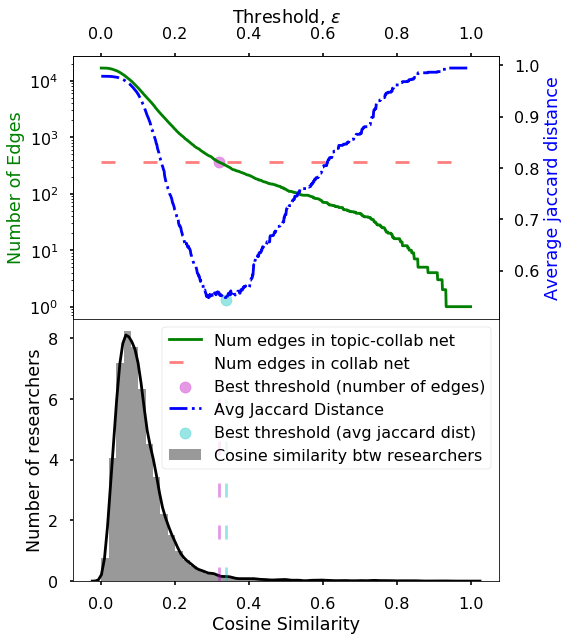

In [12]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    np.sum(adj_mat)//2,
    cosim
)

In [13]:
f.savefig('IMG/tfidf_thresholding.png', format='png', bbox_inches='tight')

### Generate network

In [14]:
model_adj_mat = set_edges(cosim, best_threshold,binary=True)

2018-04-11 22:32:18,535 : INFO : dimension: 184, 184


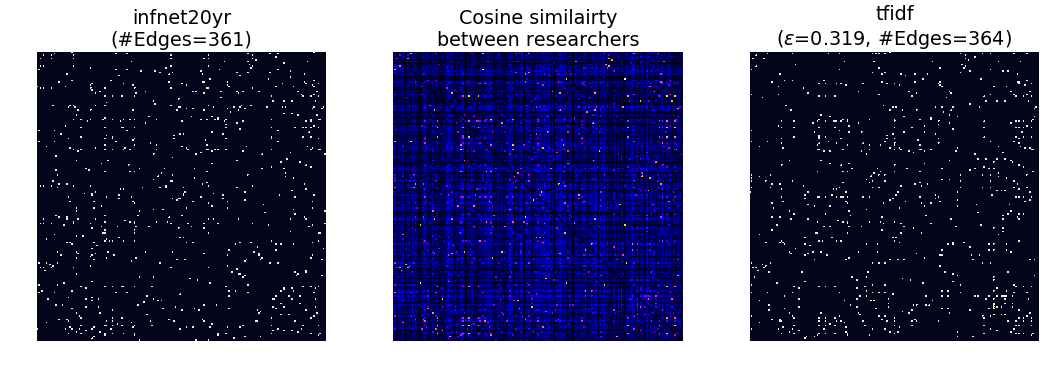

In [15]:
# visualise matrix
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet20yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(model_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('tfidf\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(model_adj_mat) // 2)))

f.tight_layout()

In [16]:
g_tfidf = adj_mat_to_graph(model_adj_mat, collabnet.id.tolist())

In [17]:
print(nx.info(g_tfidf))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 364
Average degree:   4.3855


2018-04-11 22:32:19,582 : INFO : SAVE_GRAPHS: True


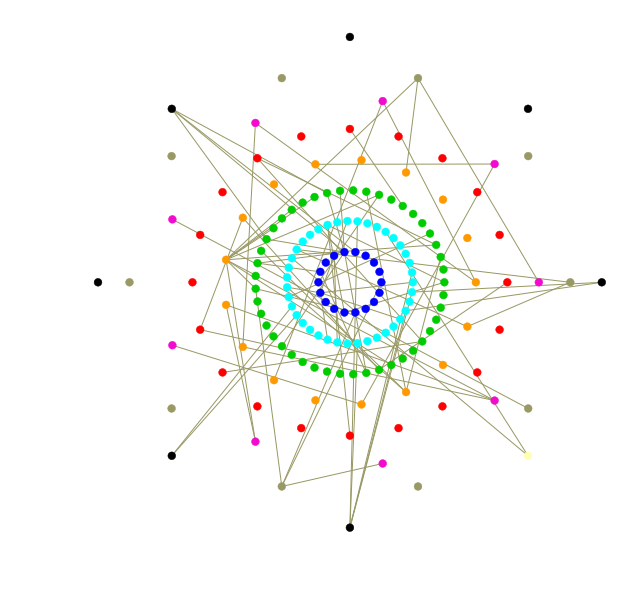

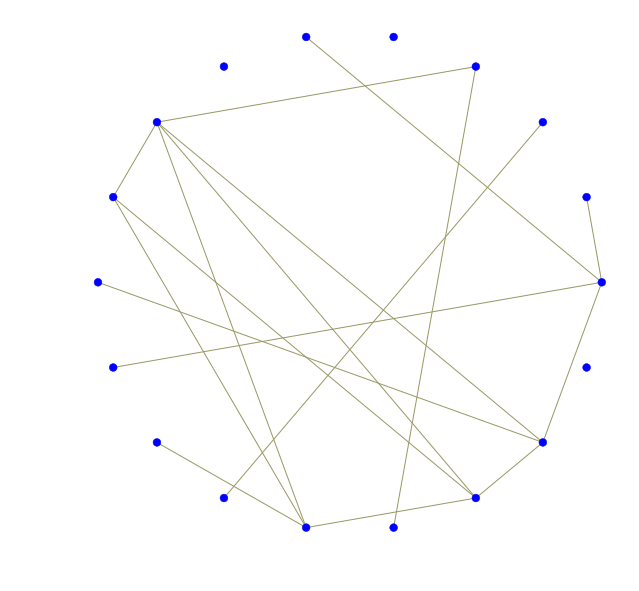

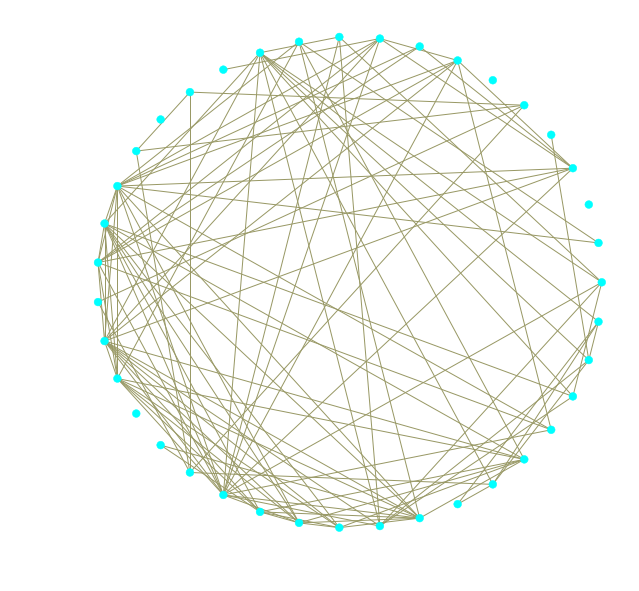

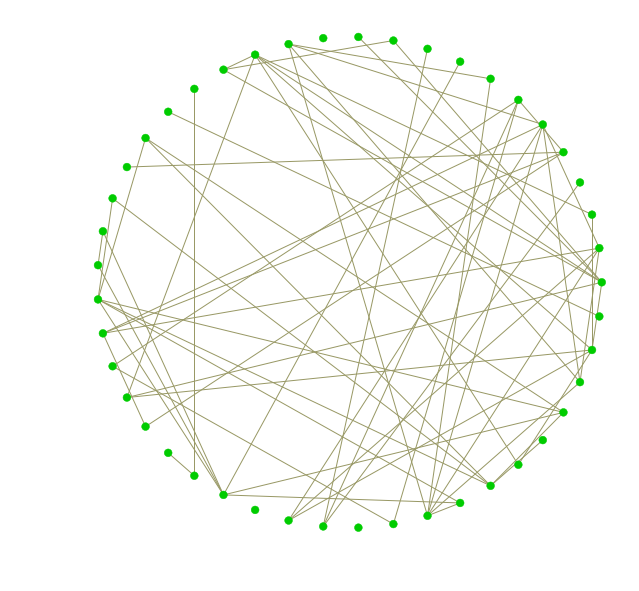

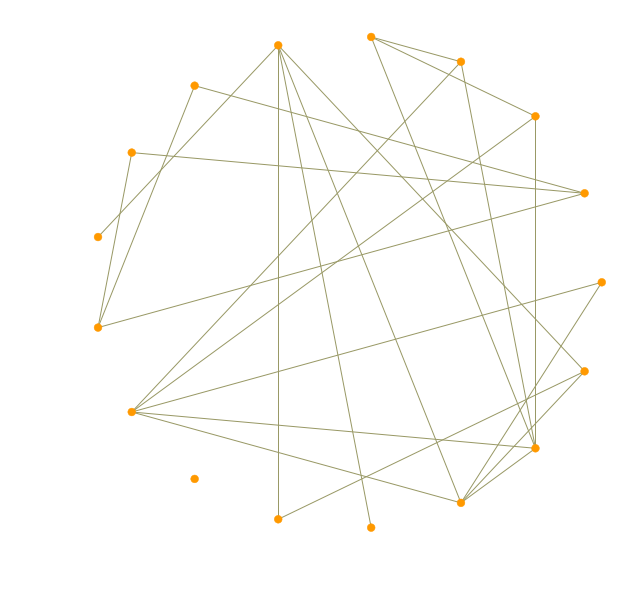

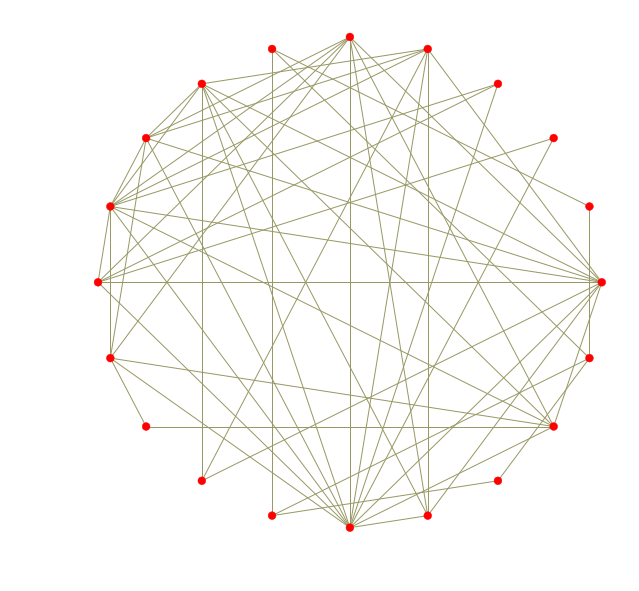

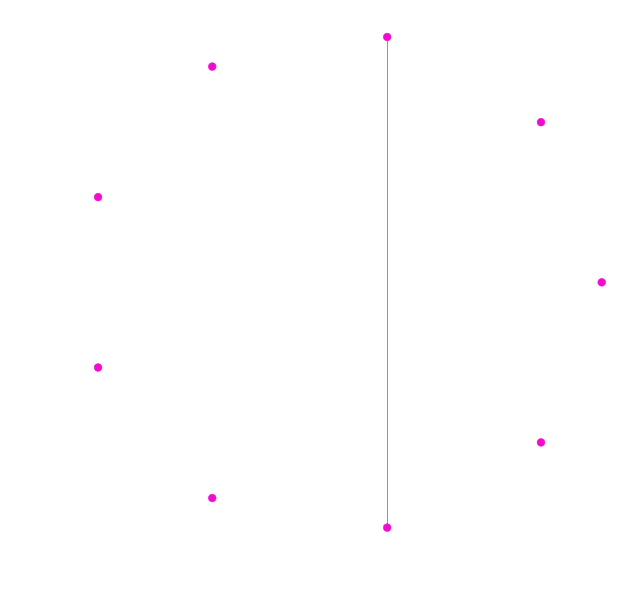

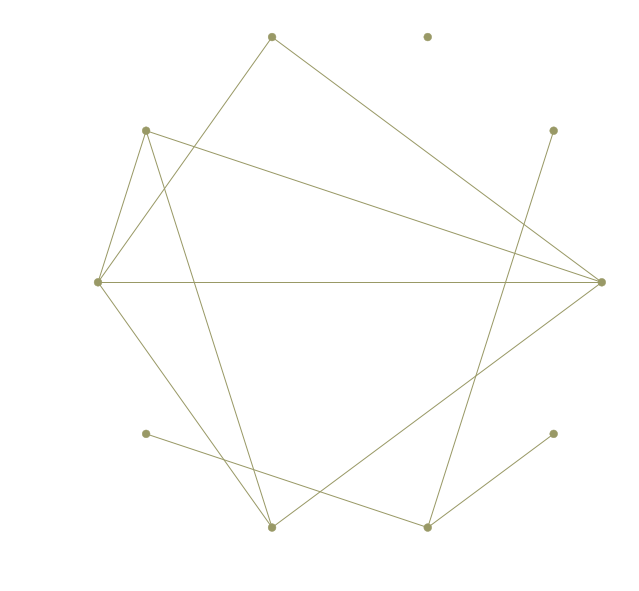

In [18]:
artist.draw_default_layout(
    g_tfidf,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='tfidf_6yr',
    SAVE_GRAPHS=True)

2018-04-11 22:32:22,398 : INFO : SAVE_GRAPHS: True


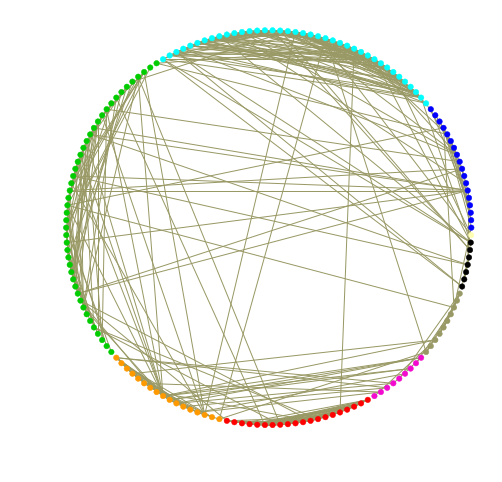

In [19]:
artist.draw_circular_layout(
    g_tfidf,
    get_lookup_poinf(),
    file_prefix='tfidf_6yr',
    SAVE_GRAPHS=True)

### Descriptive statistics

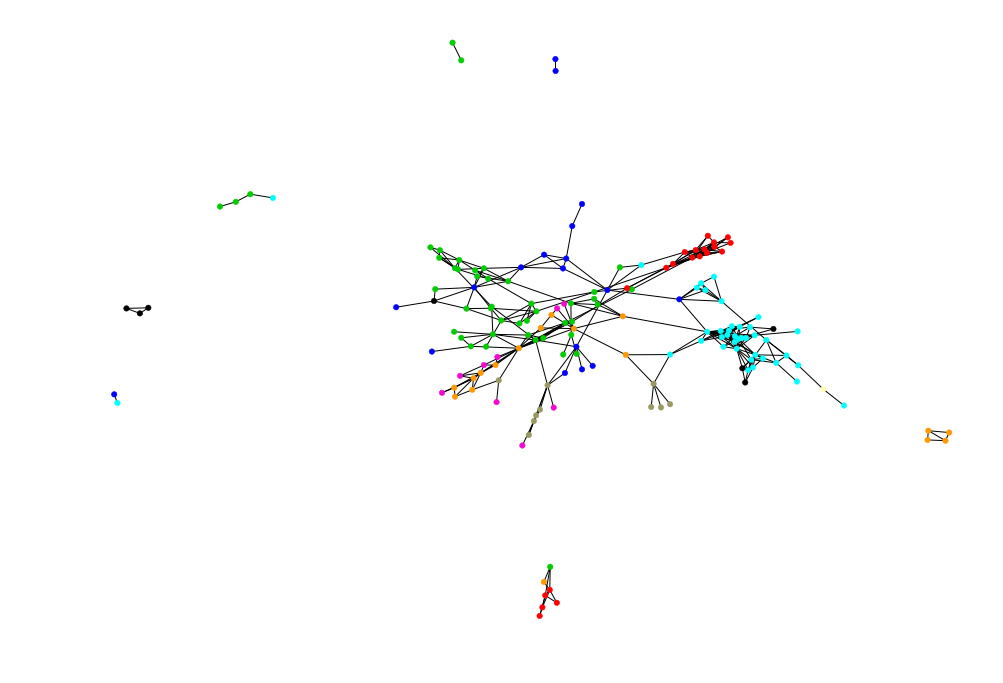

In [22]:
nx.draw(
    g_tfidf,
    pos=nx.spring_layout(g_tfidf),
    node_size=30,
    node_color=artist.color_by_inst(g_tfidf, get_lookup_poinf()))

In [23]:
gccs = generateGCC(g_tfidf)

component 1: 85.54%
component 2: 4.22%
component 3: 2.41%
component 4: 2.41%
component 5: 1.81%
component 6: 1.20%
component 7: 1.20%
component 8: 1.20%


In [24]:
c_coeff,avg=clustering_coeff(g_tfidf)
print(avg)

0.49925783720964445


In [25]:
# transitivity
nx.transitivity(g_tfidf)

0.4975822050290135

In [26]:
x = nx.degree_histogram(g_tfidf)
print(x[0]+x[1])

28


---

# topic-collaboration networks

## `topicnet-20yr`
Created using:
1. infnet-20yr
2. tm-20yr

In [27]:
# filter our lookup table according to the tokens
lookup_combined_toks = prepare_toks(top=1997, bottom=2017)

### Deriving `topicnet-20yr`#

In [28]:
# Load Collaboration Network
collabnet = pd.read_csv('../../data/data_schoolofinf/poinf_collabgraph_1997-2017.txt', 
                       sep='\n',
                       names=['id'])
adj_mat = np.load('../../data/data_schoolofinf/mat/infnet20yrs-adj-mat.pkl')

In [29]:
# Gather the publications for each individual:
topicnet = collabnet.join(df_pubmapping, how='left', on='id')

In [30]:
# Load Topic Model
tm = models.LdaModel.load('../../topicModel/src/tmfull_meta/res/best_ldamodel')
print((tm.minimum_probability))
dict_tm = Dictionary.load('../../data/data_schoolofinf/corpora/dictionary.meta')

# Generate tokens for each publication:
topicnet['toks'] = topicnet['pub_ids'].apply(lambda a: gen_toks(a, lookup_combined_toks))

2018-04-11 22:35:42,975 : INFO : loading LdaModel object from ../../topicModel/src/tmfull_meta/res/best_ldamodel
2018-04-11 22:35:42,997 : INFO : loading expElogbeta from ../../topicModel/src/tmfull_meta/res/best_ldamodel.expElogbeta.npy with mmap=None
2018-04-11 22:35:43,024 : INFO : setting ignored attribute dispatcher to None
2018-04-11 22:35:43,025 : INFO : setting ignored attribute state to None
2018-04-11 22:35:43,025 : INFO : setting ignored attribute id2word to None
2018-04-11 22:35:43,028 : INFO : loaded ../../topicModel/src/tmfull_meta/res/best_ldamodel
2018-04-11 22:35:43,029 : INFO : loading LdaModel object from ../../topicModel/src/tmfull_meta/res/best_ldamodel.state
2018-04-11 22:35:43,066 : INFO : loaded ../../topicModel/src/tmfull_meta/res/best_ldamodel.state
2018-04-11 22:35:43,079 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.meta
2018-04-11 22:35:43,095 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.meta


0.01


In [31]:
# use TM for infernece on the model
topicnet['topic_probs'] = topicnet['toks'].apply(lambda a: tm.get_document_topics(dict_tm.doc2bow(a))
                                                if len(a) else None)

In [32]:
# Generate cosine similarity between individuals:
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [10]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-04-06 20:02:46,313 : INFO : Number of ground_truth_edges: 471.0
2018-04-06 20:02:46,314 : INFO : binary edges: True
2018-04-06 20:02:46,322 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.975 num_edges: 18504
2018-04-06 20:02:46,329 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.974 num_edges: 18369
2018-04-06 20:02:46,336 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.974 num_edges: 18231
2018-04-06 20:02:46,343 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.974 num_edges: 18094
2018-04-06 20:02:46,350 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.974 num_edges: 17949
2018-04-06 20:02:46,357 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.974 num_edges: 17829
2018-04-06 20:02:46,363 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.973 num_edges: 17690
2018-04-06 20:02:46,370 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.973 num_edges: 17542
2018-04-06 20:02:46,376 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.973 num_edges: 17401
2018-04-06 20:02:46,383 : INFO : epoch 9: threshold

2018-04-06 20:02:46,908 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.948 num_edges: 9793
2018-04-06 20:02:46,915 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.947 num_edges: 9732
2018-04-06 20:02:46,922 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.947 num_edges: 9666
2018-04-06 20:02:46,929 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.947 num_edges: 9615
2018-04-06 20:02:46,936 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.947 num_edges: 9566
2018-04-06 20:02:46,943 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.946 num_edges: 9502
2018-04-06 20:02:46,950 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.946 num_edges: 9435
2018-04-06 20:02:46,956 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.946 num_edges: 9378
2018-04-06 20:02:46,963 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.945 num_edges: 9328
2018-04-06 20:02:46,970 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.945 num_edges: 9266
2018-04-06 20:02:46,977 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.945 num_

2018-04-06 20:02:47,519 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.922 num_edges: 6150
2018-04-06 20:02:47,526 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.922 num_edges: 6111
2018-04-06 20:02:47,533 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.921 num_edges: 6082
2018-04-06 20:02:47,540 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.921 num_edges: 6057
2018-04-06 20:02:47,547 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.921 num_edges: 6044
2018-04-06 20:02:47,553 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.921 num_edges: 6027
2018-04-06 20:02:47,560 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.921 num_edges: 6004
2018-04-06 20:02:47,567 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.920 num_edges: 5976
2018-04-06 20:02:47,574 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.920 num_edges: 5951
2018-04-06 20:02:47,581 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.919 num_edges: 5919
2018-04-06 20:02:47,588 : INFO : epoch 186: threshold: 0.187 avg_dist:

2018-04-06 20:02:48,140 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.897 num_edges: 4363
2018-04-06 20:02:48,147 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.897 num_edges: 4341
2018-04-06 20:02:48,154 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.897 num_edges: 4325
2018-04-06 20:02:48,161 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.897 num_edges: 4312
2018-04-06 20:02:48,168 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.896 num_edges: 4297
2018-04-06 20:02:48,174 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.896 num_edges: 4281
2018-04-06 20:02:48,181 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.896 num_edges: 4267
2018-04-06 20:02:48,188 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.896 num_edges: 4251
2018-04-06 20:02:48,195 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.895 num_edges: 4237
2018-04-06 20:02:48,202 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.895 num_edges: 4221
2018-04-06 20:02:48,209 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-04-06 20:02:48,768 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.872 num_edges: 3191
2018-04-06 20:02:48,775 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.871 num_edges: 3175
2018-04-06 20:02:48,782 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.871 num_edges: 3165
2018-04-06 20:02:48,789 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.871 num_edges: 3157
2018-04-06 20:02:48,796 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.871 num_edges: 3146
2018-04-06 20:02:48,803 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.871 num_edges: 3139
2018-04-06 20:02:48,810 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.871 num_edges: 3127
2018-04-06 20:02:48,817 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.871 num_edges: 3121
2018-04-06 20:02:48,824 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.870 num_edges: 3110
2018-04-06 20:02:48,831 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.870 num_edges: 3102
2018-04-06 20:02:48,838 : INFO : epoch 364: threshold: 0.365 avg_dist:

2018-04-06 20:02:49,371 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.851 num_edges: 2407
2018-04-06 20:02:49,378 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.850 num_edges: 2398
2018-04-06 20:02:49,384 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.849 num_edges: 2384
2018-04-06 20:02:49,391 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.849 num_edges: 2378
2018-04-06 20:02:49,398 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.849 num_edges: 2373
2018-04-06 20:02:49,405 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.849 num_edges: 2368
2018-04-06 20:02:49,411 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.849 num_edges: 2364
2018-04-06 20:02:49,418 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.848 num_edges: 2356
2018-04-06 20:02:49,425 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.849 num_edges: 2351
2018-04-06 20:02:49,431 : INFO : epoch 452: threshold: 0.453 avg_dist: 0.849 num_edges: 2343
2018-04-06 20:02:49,438 : INFO : epoch 453: threshold: 0.454 avg_dist:

2018-04-06 20:02:49,989 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.830 num_edges: 1797
2018-04-06 20:02:49,995 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.830 num_edges: 1789
2018-04-06 20:02:50,002 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.829 num_edges: 1786
2018-04-06 20:02:50,008 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.830 num_edges: 1777
2018-04-06 20:02:50,015 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.830 num_edges: 1774
2018-04-06 20:02:50,022 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.830 num_edges: 1773
2018-04-06 20:02:50,028 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.830 num_edges: 1768
2018-04-06 20:02:50,035 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.829 num_edges: 1760
2018-04-06 20:02:50,042 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.829 num_edges: 1755
2018-04-06 20:02:50,049 : INFO : epoch 541: threshold: 0.542 avg_dist: 0.829 num_edges: 1753
2018-04-06 20:02:50,055 : INFO : epoch 542: threshold: 0.543 avg_dist:

2018-04-06 20:02:51,224 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.793 num_edges: 937
2018-04-06 20:02:51,230 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.792 num_edges: 933
2018-04-06 20:02:51,237 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.792 num_edges: 931
2018-04-06 20:02:51,243 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.791 num_edges: 929
2018-04-06 20:02:51,250 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.791 num_edges: 924
2018-04-06 20:02:51,256 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.793 num_edges: 919
2018-04-06 20:02:51,263 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.792 num_edges: 915
2018-04-06 20:02:51,270 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.792 num_edges: 910
2018-04-06 20:02:51,276 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.792 num_edges: 906
2018-04-06 20:02:51,283 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.792 num_edges: 898
2018-04-06 20:02:51,289 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.791 num

2018-04-06 20:02:51,824 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.806 num_edges: 572
2018-04-06 20:02:51,830 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.806 num_edges: 570
2018-04-06 20:02:51,837 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.807 num_edges: 566
2018-04-06 20:02:51,844 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.806 num_edges: 564
2018-04-06 20:02:51,850 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.806 num_edges: 562
2018-04-06 20:02:51,857 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.806 num_edges: 557
2018-04-06 20:02:51,864 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.808 num_edges: 554
2018-04-06 20:02:51,870 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.806 num_edges: 550
2018-04-06 20:02:51,877 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.806 num_edges: 550
2018-04-06 20:02:51,884 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.808 num_edges: 549
2018-04-06 20:02:51,890 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.809 num

2018-04-06 20:02:52,415 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.828 num_edges: 309
2018-04-06 20:02:52,422 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.827 num_edges: 305
2018-04-06 20:02:52,428 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.827 num_edges: 303
2018-04-06 20:02:52,435 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.825 num_edges: 301
2018-04-06 20:02:52,441 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.826 num_edges: 299
2018-04-06 20:02:52,483 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.830 num_edges: 294
2018-04-06 20:02:52,492 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.831 num_edges: 288
2018-04-06 20:02:52,502 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.830 num_edges: 286
2018-04-06 20:02:52,511 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.829 num_edges: 282
2018-04-06 20:02:52,520 : INFO : epoch 898: threshold: 0.899 avg_dist: 0.829 num_edges: 276
2018-04-06 20:02:52,529 : INFO : epoch 899: threshold: 0.900 avg_dist: 0.828 num

2018-04-06 20:02:53,060 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.951 num_edges: 32
2018-04-06 20:02:53,066 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.953 num_edges: 31
2018-04-06 20:02:53,073 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.956 num_edges: 30
2018-04-06 20:02:53,079 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.959 num_edges: 28
2018-04-06 20:02:53,085 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.960 num_edges: 26
2018-04-06 20:02:53,093 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.961 num_edges: 25
2018-04-06 20:02:53,099 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.961 num_edges: 24
2018-04-06 20:02:53,106 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.961 num_edges: 23
2018-04-06 20:02:53,112 : INFO : epoch 987: threshold: 0.988 avg_dist: 0.967 num_edges: 21
2018-04-06 20:02:53,119 : INFO : epoch 988: threshold: 0.989 avg_dist: 0.974 num_edges: 16
2018-04-06 20:02:53,125 : INFO : epoch 989: threshold: 0.990 avg_dist: 0.977 num_edges: 13

threshold: 0.837 dist 0.783736 (735, 0.736) edges 473/471.0 (836)


threshold: 0.837 dist 0.783736 (735, 0.736) edges 473/471.0 (836)

In [33]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, 0.837, binary=True)

2018-04-11 22:38:05,845 : INFO : dimension: 195, 195


In [12]:
# Save the topicnet adj-mat
topicnet_adj_mat.dump(open('./res/topicnet20yr_adjmat.pkl','wb'))

### Visualise

#### Thresholding:

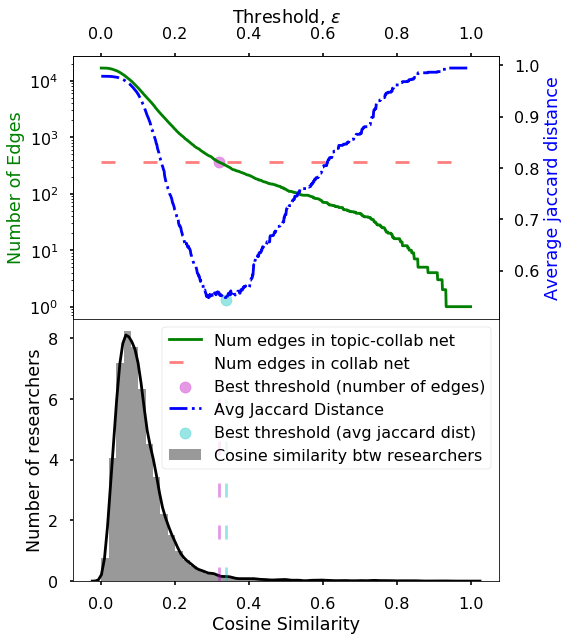

In [21]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    ground_truth_num_edges=np.sum(adj_mat)//2,
    cosim=cosim
)

In [14]:
f.savefig(
    './IMG/topicnet20yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

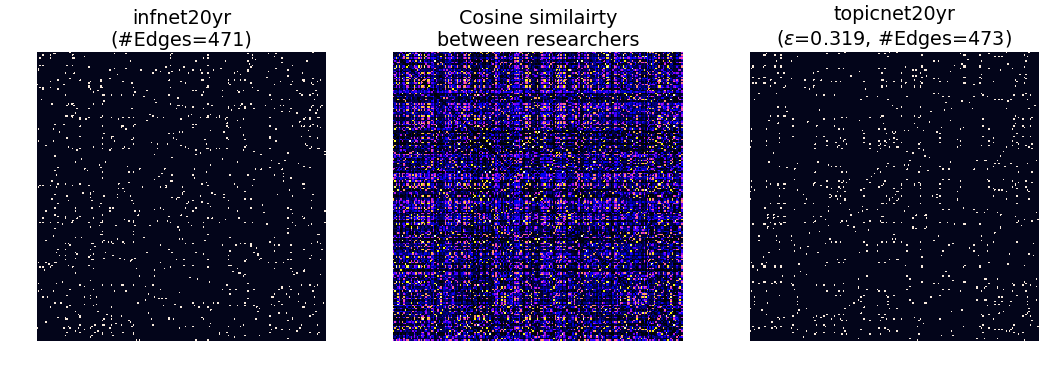

In [34]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet20yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnet20yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [16]:
f.savefig('./IMG/topicnet20yr_adjmats.png')

#### As networks:

In [35]:
g_topicnet20yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [36]:
print(nx.info(g_topicnet20yr))

Name: 
Type: Graph
Number of nodes: 169
Number of edges: 473
Average degree:   5.5976


2018-04-11 22:38:23,112 : INFO : SAVE_GRAPHS: True


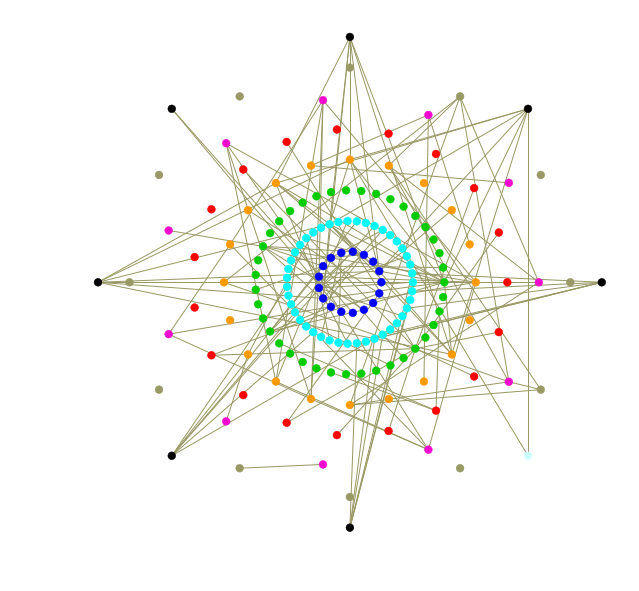

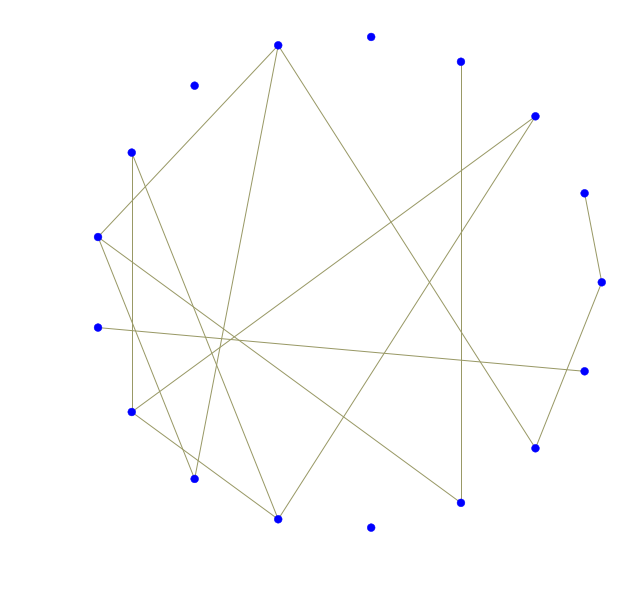

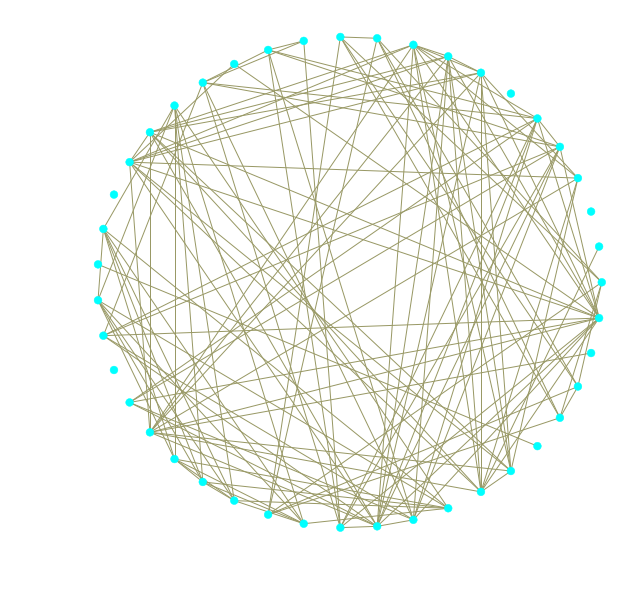

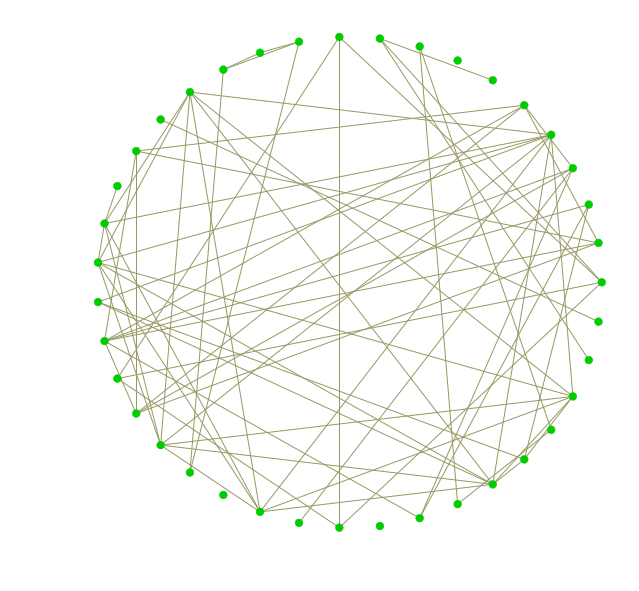

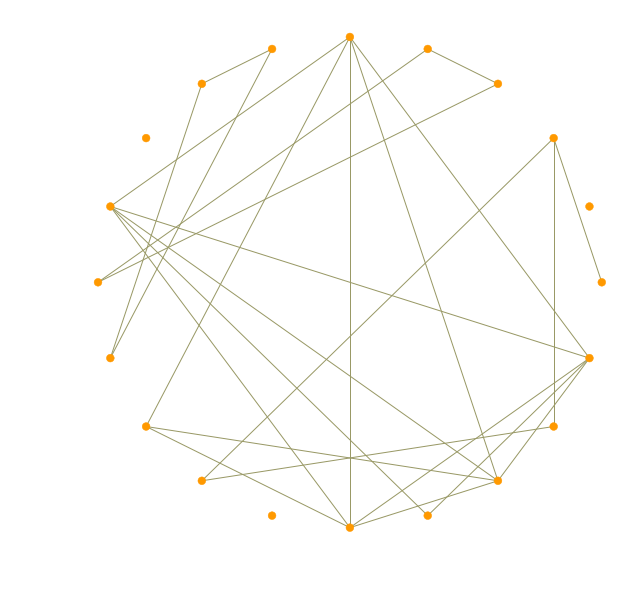

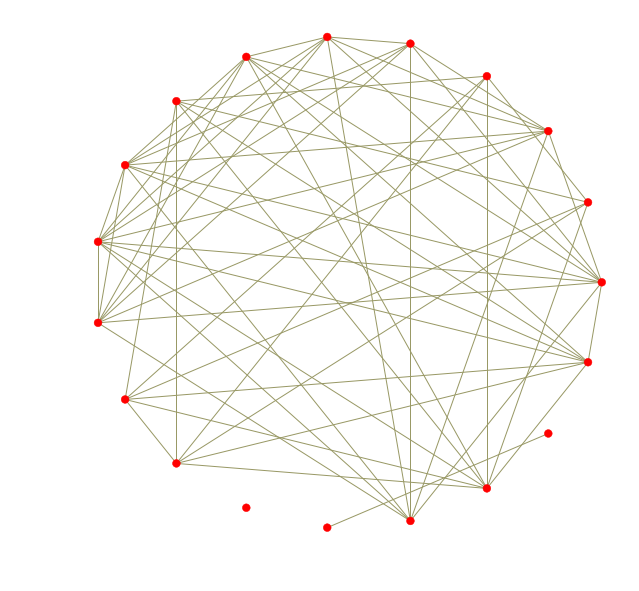

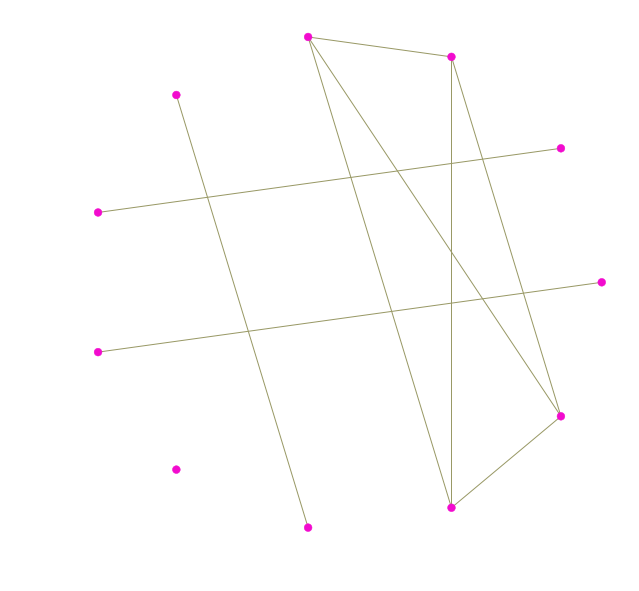

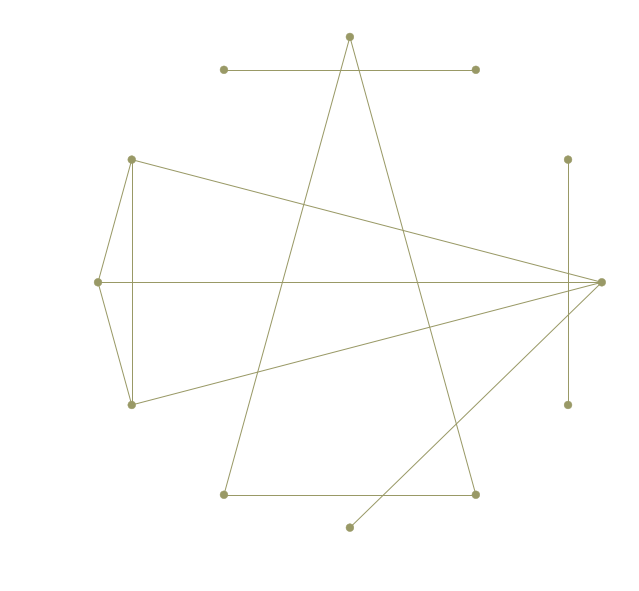

In [37]:
artist.draw_default_layout(
    g_topicnet20yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnet20yr',
    SAVE_GRAPHS=True)

2018-04-11 22:38:26,170 : INFO : SAVE_GRAPHS: True


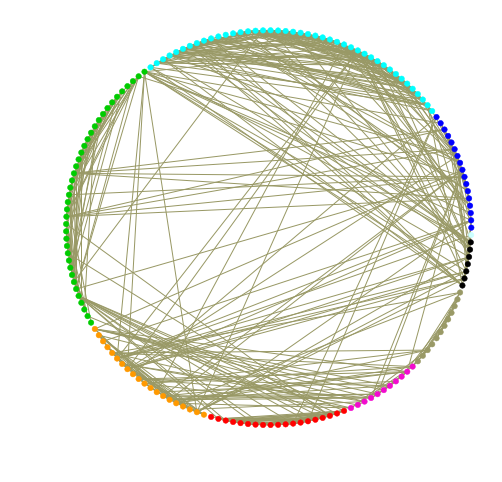

In [38]:
artist.draw_circular_layout(
    g_topicnet20yr,
    get_lookup_poinf(),
    file_prefix='topicnet20yr',
    SAVE_GRAPHS=True)

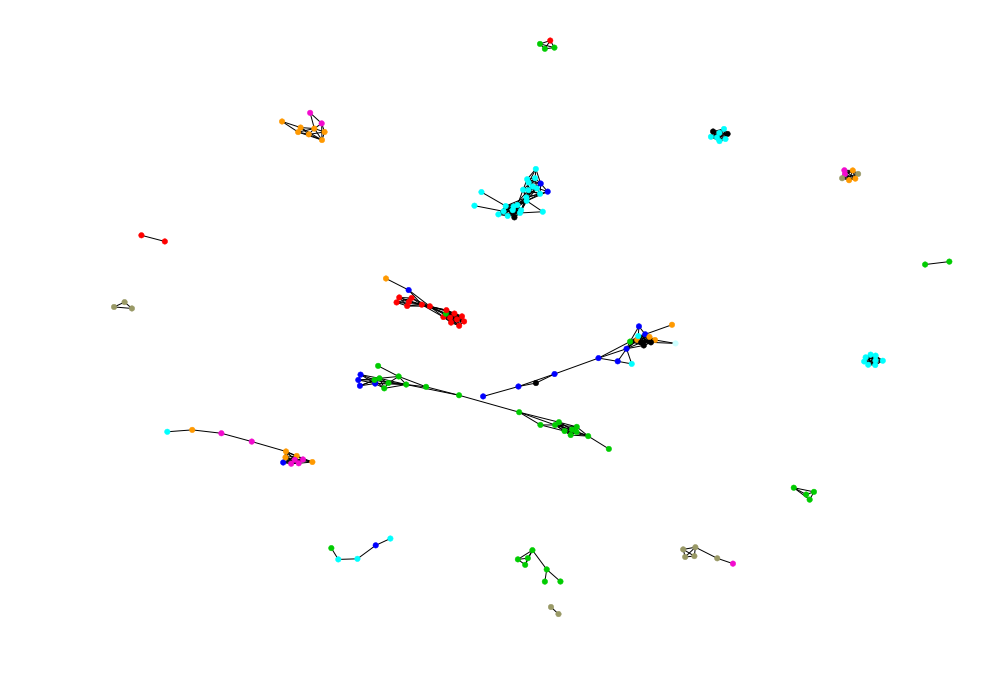

In [39]:
nx.draw(
    g_topicnet20yr,
    pos=nx.spring_layout(g_topicnet20yr),
    node_size=30,
    node_color=artist.color_by_inst(g_topicnet20yr, get_lookup_poinf()))

In [40]:
pos_topicnet20yr = nx.spring_layout(g_topicnet20yr,k=.1)

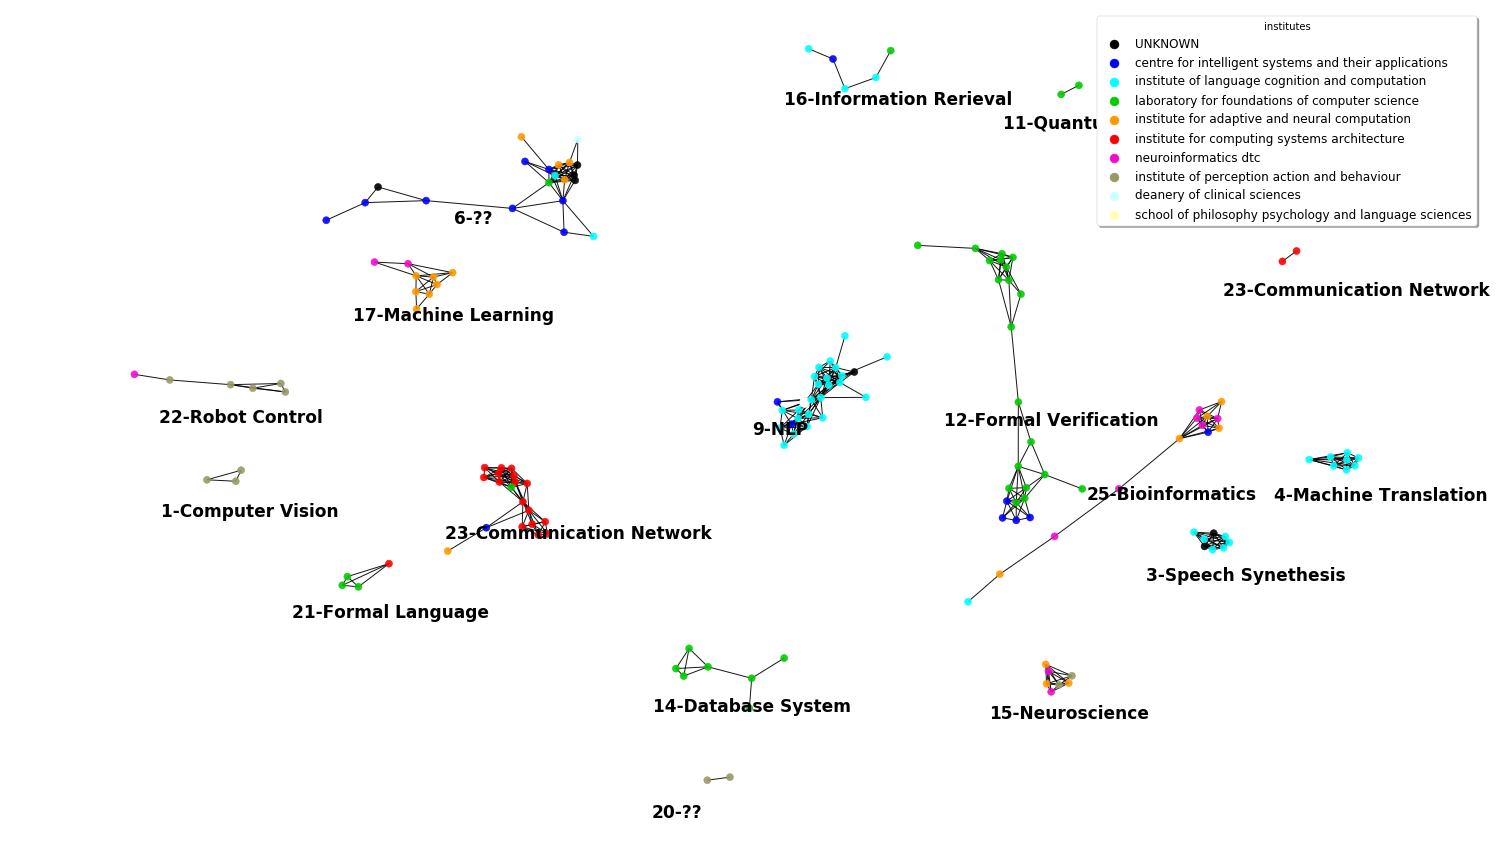

In [41]:
# Visualise with topic label
partition_dict = {}
topicnet['list_tm'] = topicnet.topic_probs.apply(lambda x: to_list(x, 30))

n = 0
for i, nodes in enumerate(nx.connected_components(g_topicnet20yr)):

    n += len(nodes)
    a = topicnet[topicnet.id.isin(nodes)].list_tm.tolist()
    topic_dist = np.mean(a, axis=0)
    partition_dict[i] = {
        'nodes': nodes,
        'topic_dist': topic_dist,
        'most_probable_topic': np.argmax(topic_dist)
    }
    
topics = [
    3, 7, 14, 4, 24, 0, 2, 17, 20, 16, 11, 21, 13, 8, 18, 1, 5, 22, 19, 23,
    9,12, 15, 6, 10
]
labels = [
    'Machine Translation', 'IRR', 'Neuroscience', 'IRR', 'Bioinformatics',
    'Computer Vision', 'Speech Synethesis', 'Relational Algebra (?)',
    'Formal Language', 'Machine Learning', 'Formal Verification',
    'Robot Control', 'Database System', 'NLP', 'Agent Based System',
    'Compiler Optimisation', '??', 'Communication Network', '??',
    'Computer simulation', 'Cognitive Science', 'Algorithm',
    'Information Rerieval', 'Formal Logic (?)', 'Quantum Computing (?)'
]

TOPIC_DICT = dict((a,b) for a,b in zip(topics,labels))

f = plt.figure(figsize=(20, 12))
ax = f.add_subplot(111)

nx.draw(
    g_topicnet20yr,
    pos=pos_topicnet20yr,
    ax=ax,
    node_size=50,
    alpha=.9,
    node_color=artist.color_by_inst(g_topicnet20yr, get_lookup_poinf()))

for _, node_dict in list(partition_dict.items()):
    # calculate average position:
    pos_x, pos_y = 0, 0
    for node in node_dict['nodes']:
        pos_x += pos_topicnet20yr[node][0]
        pos_y += pos_topicnet20yr[node][1]
    pos_x /= len(node_dict['nodes'])
    pos_y /= len(node_dict['nodes'])
    topic_num = node_dict['most_probable_topic']
    ax.text(
        pos_x-.1,
        pos_y - .1,
        "{}-{}".format(topic_num + 1, TOPIC_DICT[topic_num]),
        withdash=True,
        size=17,
        weight='bold')
#     print((node_dict['most_probable_topic']))

artist.add_inst_labels(ax)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, 1.),
    ncol=1,
    title='institutes',
    fontsize=12,
    fancybox=True,
    shadow=True)
f.tight_layout()

In [34]:
f.savefig('IMG/topicnet20yr_w_topics.pdf',format='pdf',bbox_inches='tight')

### Descriptive statistics

In [42]:
gccs = generateGCC(g_topicnet20yr)

component 1: 15.38%
component 2: 14.20%
component 3: 11.83%
component 4: 11.24%
component 5: 7.69%
component 6: 5.33%
component 7: 4.73%
component 8: 4.73%
component 9: 4.14%
component 10: 4.14%
component 11: 3.55%
component 12: 2.96%
component 13: 2.37%
component 14: 2.37%
component 15: 1.78%
component 16: 1.18%
component 17: 1.18%
component 18: 1.18%


In [43]:
nx.average_clustering(g_topicnet20yr,count_zeros=False)

0.8174458366359769

In [44]:
# Clustering coefficient
c_coeff,avg=clustering_coeff(g_topicnet20yr)
print(avg)

0.6868479810787503


In [45]:
# transitivity
nx.transitivity(g_topicnet20yr)

0.7556427870461236

In [46]:
# degree dist
nx.degree_histogram(g_topicnet20yr)

[0, 19, 18, 21, 12, 10, 16, 26, 14, 13, 9, 6, 3, 0, 0, 1, 1]

## `topicnetref-20yr`

Created using
1. infnet20yr
2. tm-dblp

### Deriving `topicnetref-20yr`

In [47]:
# Since we are using the same base, we do not need to reload it again!
# Loading the new topic model:
tm = models.LdaModel.load('../../topicModel/src/tmdblp/tm_dblp')
dict_tm = Dictionary.load(
    '../../data/data_dblp/corpora/dictionary.dblp.1997-2017')

2018-04-11 22:38:45,336 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp
2018-04-11 22:38:45,343 : INFO : loading expElogbeta from ../../topicModel/src/tmdblp/tm_dblp.expElogbeta.npy with mmap=None
2018-04-11 22:38:45,936 : INFO : setting ignored attribute id2word to None
2018-04-11 22:38:45,937 : INFO : setting ignored attribute dispatcher to None
2018-04-11 22:38:45,938 : INFO : setting ignored attribute state to None
2018-04-11 22:38:45,938 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp
2018-04-11 22:38:45,939 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp.state
2018-04-11 22:38:47,188 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp.state
2018-04-11 22:38:47,232 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-04-11 22:38:47,280 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [48]:
# Generate topic probabilities for each publication using the dictionary for DBLP
tm.minimum_probability = 0.001
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)) if len(a) else None)

In [49]:
# Generate cosine similarity
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [50]:
# find best threshold
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-04-11 22:39:00,146 : INFO : Number of ground_truth_edges: 471.0
2018-04-11 22:39:00,148 : INFO : binary edges: True
2018-04-11 22:39:00,160 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.975 num_edges: 18900
2018-04-11 22:39:00,174 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.975 num_edges: 18895
2018-04-11 22:39:00,184 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.975 num_edges: 18885
2018-04-11 22:39:00,194 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.975 num_edges: 18864
2018-04-11 22:39:00,205 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.975 num_edges: 18843
2018-04-11 22:39:00,218 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.975 num_edges: 18817
2018-04-11 22:39:00,229 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.975 num_edges: 18783
2018-04-11 22:39:00,237 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.975 num_edges: 18745
2018-04-11 22:39:00,247 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.975 num_edges: 18713
2018-04-11 22:39:00,256 : INFO : epoch 9: threshold

2018-04-11 22:39:01,086 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.962 num_edges: 12689
2018-04-11 22:39:01,095 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.961 num_edges: 12615
2018-04-11 22:39:01,111 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.961 num_edges: 12540
2018-04-11 22:39:01,120 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.961 num_edges: 12461
2018-04-11 22:39:01,131 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.961 num_edges: 12381
2018-04-11 22:39:01,142 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.960 num_edges: 12299
2018-04-11 22:39:01,151 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.960 num_edges: 12235
2018-04-11 22:39:01,165 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.960 num_edges: 12162
2018-04-11 22:39:01,175 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.960 num_edges: 12079
2018-04-11 22:39:01,190 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.959 num_edges: 12010
2018-04-11 22:39:01,200 : INFO : epoch 97: threshold: 0.098 avg_dist: 

2018-04-11 22:39:01,915 : INFO : epoch 175: threshold: 0.176 avg_dist: 0.936 num_edges: 7861
2018-04-11 22:39:01,922 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.936 num_edges: 7834
2018-04-11 22:39:01,932 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.936 num_edges: 7799
2018-04-11 22:39:01,941 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.935 num_edges: 7770
2018-04-11 22:39:01,953 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.935 num_edges: 7737
2018-04-11 22:39:01,964 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.935 num_edges: 7695
2018-04-11 22:39:01,973 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.934 num_edges: 7659
2018-04-11 22:39:01,983 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.934 num_edges: 7616
2018-04-11 22:39:01,992 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.934 num_edges: 7577
2018-04-11 22:39:02,005 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.934 num_edges: 7547
2018-04-11 22:39:02,017 : INFO : epoch 185: threshold: 0.186 avg_dist:

2018-04-11 22:39:02,733 : INFO : epoch 264: threshold: 0.265 avg_dist: 0.910 num_edges: 5297
2018-04-11 22:39:02,740 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.910 num_edges: 5283
2018-04-11 22:39:02,749 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.909 num_edges: 5261
2018-04-11 22:39:02,758 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.909 num_edges: 5248
2018-04-11 22:39:02,765 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.909 num_edges: 5231
2018-04-11 22:39:02,772 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.908 num_edges: 5212
2018-04-11 22:39:02,782 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.908 num_edges: 5197
2018-04-11 22:39:02,790 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.908 num_edges: 5185
2018-04-11 22:39:02,806 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.907 num_edges: 5163
2018-04-11 22:39:02,813 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.907 num_edges: 5139
2018-04-11 22:39:02,824 : INFO : epoch 274: threshold: 0.275 avg_dist:

2018-04-11 22:39:03,537 : INFO : epoch 353: threshold: 0.354 avg_dist: 0.881 num_edges: 3789
2018-04-11 22:39:03,545 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.881 num_edges: 3776
2018-04-11 22:39:03,552 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.881 num_edges: 3757
2018-04-11 22:39:03,560 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.880 num_edges: 3747
2018-04-11 22:39:03,572 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.879 num_edges: 3728
2018-04-11 22:39:03,579 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.878 num_edges: 3708
2018-04-11 22:39:03,587 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.877 num_edges: 3688
2018-04-11 22:39:03,595 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.877 num_edges: 3676
2018-04-11 22:39:03,603 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.876 num_edges: 3667
2018-04-11 22:39:03,616 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.876 num_edges: 3655
2018-04-11 22:39:03,623 : INFO : epoch 363: threshold: 0.364 avg_dist:

2018-04-11 22:39:04,263 : INFO : epoch 441: threshold: 0.442 avg_dist: 0.849 num_edges: 2764
2018-04-11 22:39:04,271 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.849 num_edges: 2756
2018-04-11 22:39:04,280 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.849 num_edges: 2747
2018-04-11 22:39:04,288 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.848 num_edges: 2744
2018-04-11 22:39:04,296 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.848 num_edges: 2739
2018-04-11 22:39:04,303 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.848 num_edges: 2730
2018-04-11 22:39:04,311 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.847 num_edges: 2721
2018-04-11 22:39:04,320 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.847 num_edges: 2709
2018-04-11 22:39:04,328 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.847 num_edges: 2705
2018-04-11 22:39:04,339 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.847 num_edges: 2698
2018-04-11 22:39:04,347 : INFO : epoch 451: threshold: 0.452 avg_dist:

2018-04-11 22:39:05,003 : INFO : epoch 530: threshold: 0.531 avg_dist: 0.831 num_edges: 2068
2018-04-11 22:39:05,011 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.831 num_edges: 2066
2018-04-11 22:39:05,022 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.830 num_edges: 2060
2018-04-11 22:39:05,030 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.830 num_edges: 2051
2018-04-11 22:39:05,037 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.832 num_edges: 2043
2018-04-11 22:39:05,044 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.831 num_edges: 2036
2018-04-11 22:39:05,052 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.831 num_edges: 2031
2018-04-11 22:39:05,059 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.830 num_edges: 2021
2018-04-11 22:39:05,072 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.831 num_edges: 2017
2018-04-11 22:39:05,080 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.831 num_edges: 2012
2018-04-11 22:39:05,090 : INFO : epoch 540: threshold: 0.541 avg_dist:

2018-04-11 22:39:05,741 : INFO : epoch 619: threshold: 0.620 avg_dist: 0.809 num_edges: 1583
2018-04-11 22:39:05,753 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.808 num_edges: 1578
2018-04-11 22:39:05,761 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.808 num_edges: 1575
2018-04-11 22:39:05,768 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.809 num_edges: 1567
2018-04-11 22:39:05,775 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.808 num_edges: 1561
2018-04-11 22:39:05,783 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.812 num_edges: 1554
2018-04-11 22:39:05,790 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.812 num_edges: 1550
2018-04-11 22:39:05,798 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.811 num_edges: 1545
2018-04-11 22:39:05,808 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.811 num_edges: 1540
2018-04-11 22:39:05,815 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.811 num_edges: 1537
2018-04-11 22:39:05,825 : INFO : epoch 629: threshold: 0.630 avg_dist:

2018-04-11 22:39:06,519 : INFO : epoch 708: threshold: 0.709 avg_dist: 0.793 num_edges: 1182
2018-04-11 22:39:06,529 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.794 num_edges: 1179
2018-04-11 22:39:06,540 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.795 num_edges: 1176
2018-04-11 22:39:06,547 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.796 num_edges: 1170
2018-04-11 22:39:06,555 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.796 num_edges: 1163
2018-04-11 22:39:06,567 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.796 num_edges: 1161
2018-04-11 22:39:06,577 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.795 num_edges: 1153
2018-04-11 22:39:06,585 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.795 num_edges: 1148
2018-04-11 22:39:06,593 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.795 num_edges: 1142
2018-04-11 22:39:06,601 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.794 num_edges: 1137
2018-04-11 22:39:06,611 : INFO : epoch 718: threshold: 0.719 avg_dist:

2018-04-11 22:39:07,271 : INFO : epoch 797: threshold: 0.798 avg_dist: 0.810 num_edges: 703
2018-04-11 22:39:07,278 : INFO : epoch 798: threshold: 0.799 avg_dist: 0.810 num_edges: 699
2018-04-11 22:39:07,290 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.809 num_edges: 696
2018-04-11 22:39:07,297 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.808 num_edges: 690
2018-04-11 22:39:07,305 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.811 num_edges: 682
2018-04-11 22:39:07,313 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.812 num_edges: 678
2018-04-11 22:39:07,323 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.812 num_edges: 672
2018-04-11 22:39:07,329 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.811 num_edges: 670
2018-04-11 22:39:07,336 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.811 num_edges: 663
2018-04-11 22:39:07,344 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.812 num_edges: 659
2018-04-11 22:39:07,350 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.812 num

2018-04-11 22:39:08,068 : INFO : epoch 887: threshold: 0.888 avg_dist: 0.869 num_edges: 302
2018-04-11 22:39:08,080 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.868 num_edges: 299
2018-04-11 22:39:08,088 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.868 num_edges: 298
2018-04-11 22:39:08,096 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.868 num_edges: 297
2018-04-11 22:39:08,105 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.867 num_edges: 292
2018-04-11 22:39:08,112 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.867 num_edges: 287
2018-04-11 22:39:08,119 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.868 num_edges: 281
2018-04-11 22:39:08,131 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.867 num_edges: 278
2018-04-11 22:39:08,139 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.869 num_edges: 275
2018-04-11 22:39:08,153 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.881 num_edges: 271
2018-04-11 22:39:08,163 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.882 num

2018-04-11 22:39:08,810 : INFO : epoch 977: threshold: 0.978 avg_dist: 0.975 num_edges: 18
2018-04-11 22:39:08,819 : INFO : epoch 978: threshold: 0.979 avg_dist: 0.977 num_edges: 17
2018-04-11 22:39:08,827 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.976 num_edges: 16
2018-04-11 22:39:08,834 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.981 num_edges: 15
2018-04-11 22:39:08,847 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.981 num_edges: 15
2018-04-11 22:39:08,857 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.985 num_edges: 12
2018-04-11 22:39:08,864 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.986 num_edges: 11
2018-04-11 22:39:08,871 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.986 num_edges: 11
2018-04-11 22:39:08,878 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.988 num_edges: 8
2018-04-11 22:39:08,885 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.988 num_edges: 8
2018-04-11 22:39:08,893 : INFO : epoch 987: threshold: 0.988 avg_dist: 0.988 num_edges: 8
20

threshold: 0.850 dist 0.792538 (723, 0.724) edges 474/471.0 (849)


threshold: 0.850 dist 0.792538 (723, 0.724) edges 474/471.0 (849)

In [51]:
# set edges:
topicnet_adj_mat = set_edges(cosim, 0.850, binary=True)

2018-04-11 22:39:13,346 : INFO : dimension: 195, 195


In [44]:
topicnet_adj_mat.dump(open('./res/topicnetref-20yr_adjmat.pkl','wb'))

### Visualise

#### Thresholding:

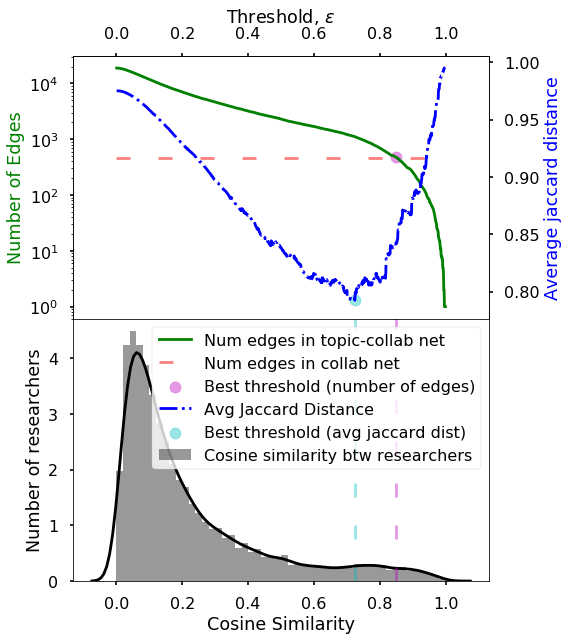

In [52]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    np.sum(adj_mat)//2,
    cosim
)

In [46]:
f.savefig('./IMG/topicnetref20yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

In [ ]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet20yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnetref20yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [48]:
f.savefig('./IMG/topicnetref20yr_adjmats.png')

#### As networks:

In [53]:
g_topicnetref20yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [54]:
print(nx.info(g_topicnetref20yr))

Name: 
Type: Graph
Number of nodes: 129
Number of edges: 474
Average degree:   7.3488


2018-04-11 22:39:27,271 : INFO : SAVE_GRAPHS: True


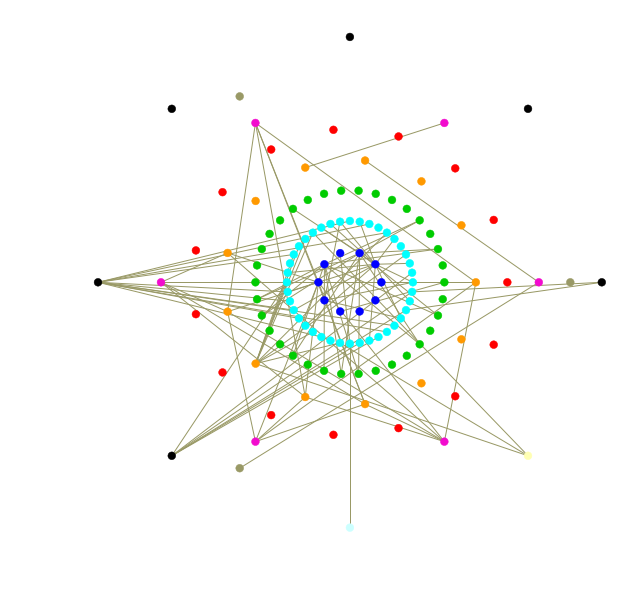

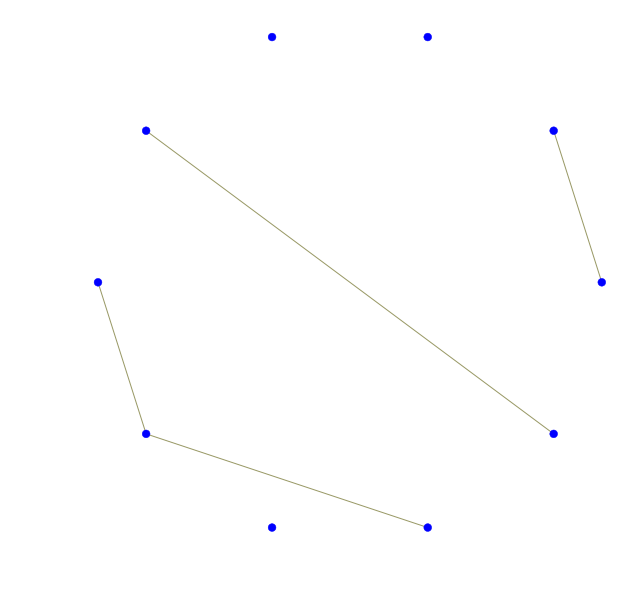

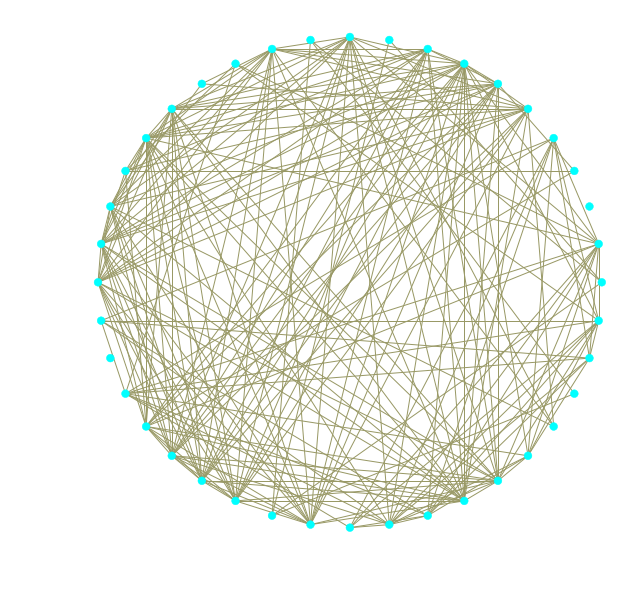

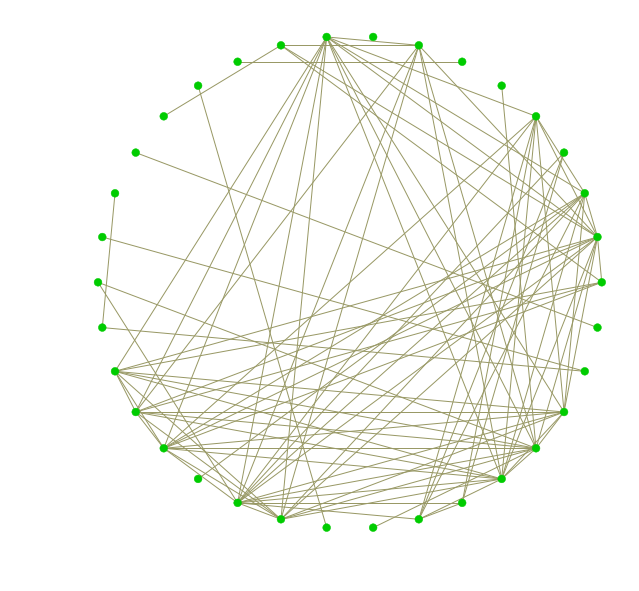

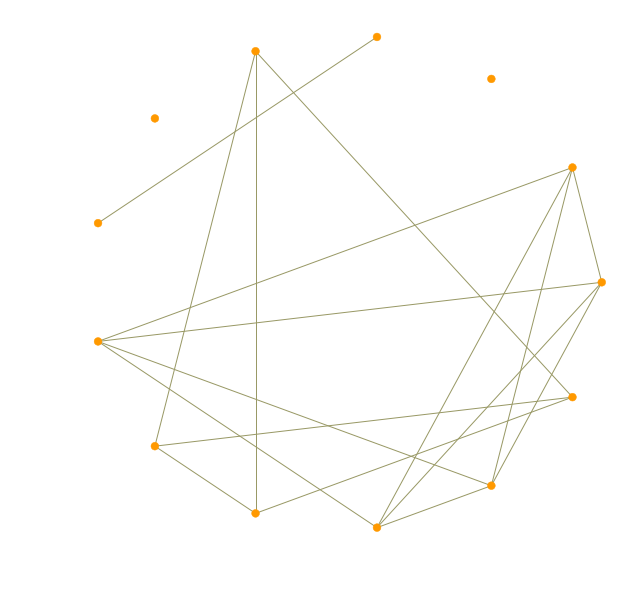

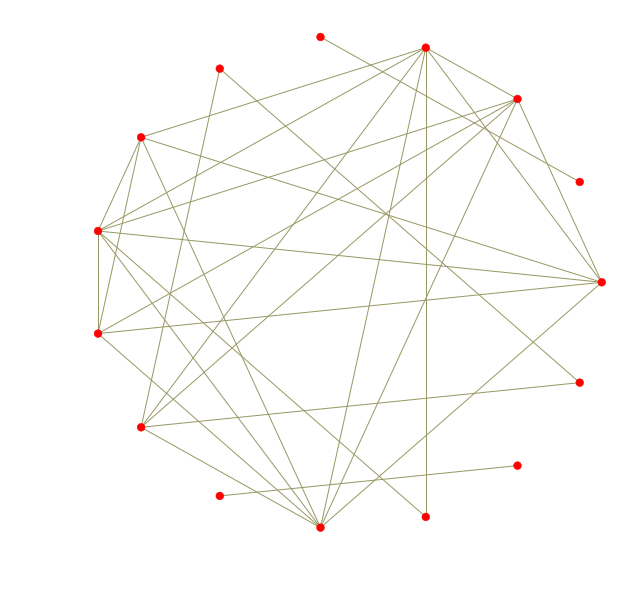

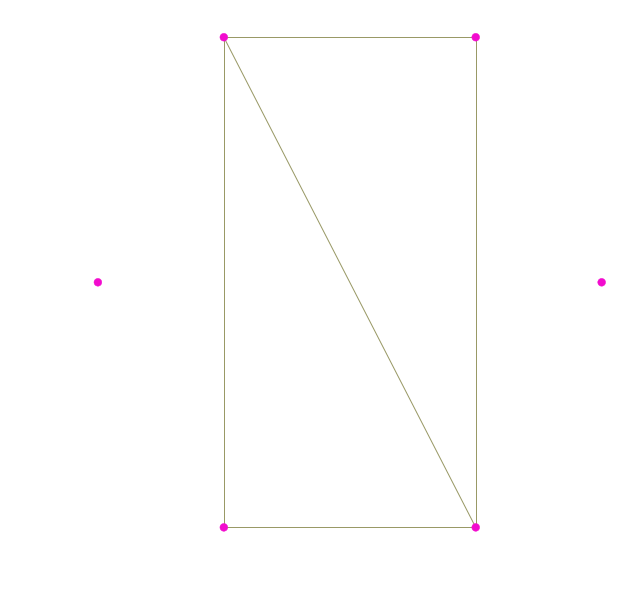

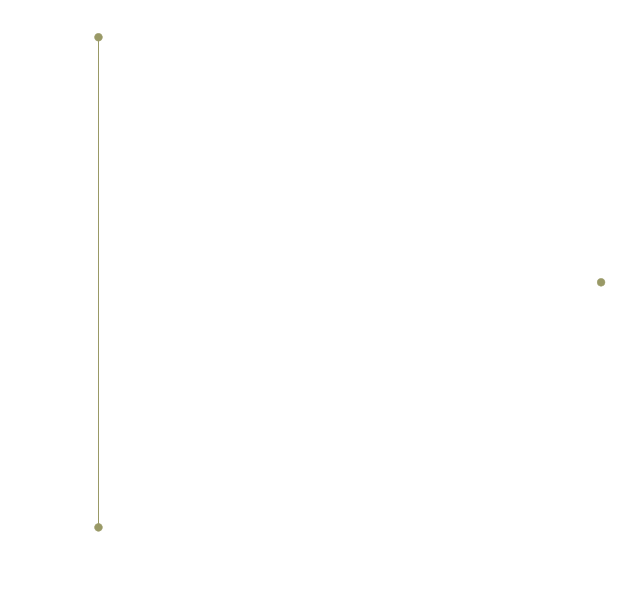

In [55]:
artist.draw_default_layout(
    g_topicnetref20yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref20yr',
    SAVE_GRAPHS=True)

2018-04-11 22:39:35,216 : INFO : SAVE_GRAPHS: False


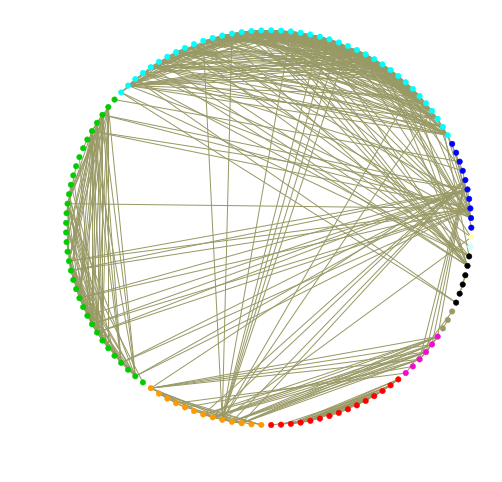

In [56]:
artist.draw_circular_layout(
    g_topicnetref20yr,
    get_lookup_poinf(),
    file_prefix='topicnetref20yr',
    SAVE_GRAPHS=False)

In [57]:
pos = nx.spring_layout(g_topicnetref20yr,k=.1)

40
80
76
64
96
43
69
71
95
8
8
36
73
15
57
5
2
76


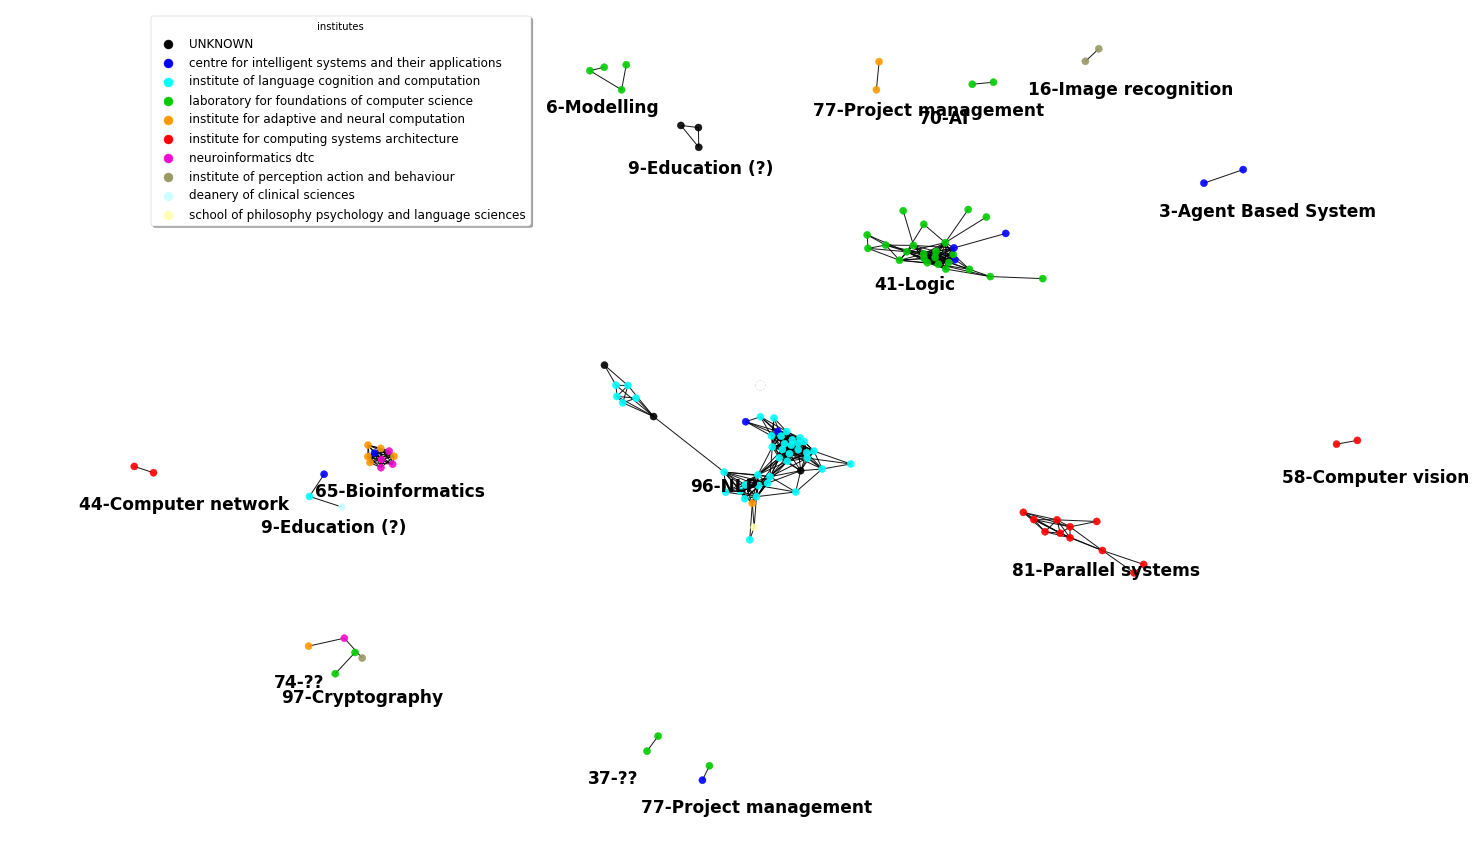

In [58]:
# Visualise with topic label
partition_dict = {}
topicnet['list_tm'] = topicnet.topic_probs.apply(lambda x: to_list(x, 100))

n = 0
for i, nodes in enumerate(nx.connected_components(g_topicnetref20yr)):

    n += len(nodes)
    a = topicnet[topicnet.id.isin(nodes)].list_tm.tolist()
    topic_dist = np.mean(a, axis=0)
    partition_dict[i] = {
        'nodes': nodes,
        'topic_dist': topic_dist,
        'most_probable_topic': np.argmax(topic_dist)
    }

dblp_ =  [(80, 'Parallel systems'),
(76, 'Project management'),
(64, 'Bioinformatics'),
(96, 'Cryptography'),
(59, 'IOT'),
(52, '??'),
(69, 'AI'),
(17, 'Social Media'),
(95, 'NLP'),
(8, 'Education (?)'),
(40, 'Logic'),
(36, 'Web (?)'),
(71, 'Probability'),
(23, 'Neural Network'),
(5, 'Modelling'),
(2, 'Agent Based System'),
(43,'Computer network'),
(36, '??'),
(73, '??'),
(15,'Image recognition'),
(57,'Computer vision'),
]

TOPIC_DICT = dict((a,b) for a,b in dblp_)

f = plt.figure(figsize=(20, 12))
ax = f.add_subplot(111)

nx.draw(
    g_topicnetref20yr,
    pos=pos,
    ax=ax,
    node_size=50,
    alpha=.9,
    node_color=artist.color_by_inst(g_topicnetref20yr, get_lookup_poinf()))

for _, node_dict in list(partition_dict.items()):
    # calculate average position:
    pos_x, pos_y = 0, 0
    for node in node_dict['nodes']:
        pos_x += pos[node][0]
        pos_y += pos[node][1]
    pos_x /= len(node_dict['nodes'])
    pos_y /= len(node_dict['nodes'])
    topic_num = node_dict['most_probable_topic']
    ax.text(
        pos_x-.1,
        pos_y - .1,
        "{}-{}".format(topic_num + 1, TOPIC_DICT[topic_num]),
        withdash=True,
        size=17,
        weight='bold')
    print((node_dict['most_probable_topic']))

artist.add_inst_labels(ax)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.2, 1.),
    ncol=1,
    title='institutes',
    fontsize=12,
    fancybox=True,
    shadow=True)
f.tight_layout()

In [ ]:
f.savefig('IMG/topicnetref20yr_w_topic.pdf',format='pdf',bbox_inches='tight')

### Descriptive statistics

In [ ]:
gccs = generateGCC(g_topicnetref20yr)

In [ ]:
# clustering coefficient
c_coeff,avg = clustering_coeff(g_topicnetref20yr)
print(avg)
print(nx.average_clustering(g_topicnetref20yr,count_zeros=False))

In [ ]:
# transitivity
print(nx.transitivity(g_topicnetref20yr))

In [ ]:
_ = nx.degree_histogram(g_topicnetref20yr)
print(_[0]+_[1])

In [ ]:
nx.degree_histogram(g_topicnetref20yr)

---
Embedding `infnet6yr`

## `topicnet-6yr`

created using
1. infnet6yr
2. tmless_meta  (tm-6yr)

### Deriving `topicnet-6yr`

In [59]:
# Filter out lookup table according to the tokens
lookup_combined_toks = prepare_toks(2012,2017)

In [60]:
# load collaboration network
collabnet = pd.read_csv(
    '../../data/data_schoolofinf/poinf_collabgraph_2012-2017.txt',
    sep='\n',
    names=['id'])
adj_mat = np.load('../../data/data_schoolofinf/mat/infnet6yrs-adj-mat.order6yr.pkl')

In [61]:
len(collabnet)

184

In [62]:
# Gather publications for each individuals
topicnet = collabnet.join(df_pubmapping, how='left',on='id')
# generate tokens
topicnet['toks'] = topicnet['pub_ids'].apply(
    lambda a: gen_toks(a, lookup_combined_toks))

In [63]:
# load topic model
tm = models.LdaModel.load('../../topicModel/src/tmrest_meta/res/best_ldamodel')
dict_tm = Dictionary.load('../../data/data_schoolofinf/corpora/dictionary.less.meta')

2018-04-11 22:39:54,447 : INFO : loading LdaModel object from ../../topicModel/src/tmrest_meta/res/best_ldamodel
2018-04-11 22:39:54,449 : INFO : loading expElogbeta from ../../topicModel/src/tmrest_meta/res/best_ldamodel.expElogbeta.npy with mmap=None
2018-04-11 22:39:54,451 : INFO : setting ignored attribute dispatcher to None
2018-04-11 22:39:54,452 : INFO : setting ignored attribute state to None
2018-04-11 22:39:54,452 : INFO : setting ignored attribute id2word to None
2018-04-11 22:39:54,453 : INFO : loaded ../../topicModel/src/tmrest_meta/res/best_ldamodel
2018-04-11 22:39:54,454 : INFO : loading LdaModel object from ../../topicModel/src/tmrest_meta/res/best_ldamodel.state
2018-04-11 22:39:54,462 : INFO : loaded ../../topicModel/src/tmrest_meta/res/best_ldamodel.state
2018-04-11 22:39:54,473 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.meta
2018-04-11 22:39:54,476 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.m

In [64]:
# inference step by tm
tm.minimum_probability=0.01
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)))

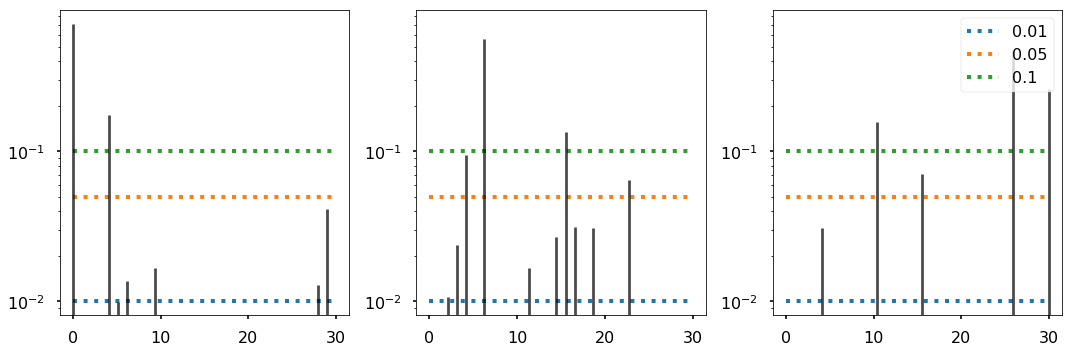

In [84]:
# start from 0 to get all the probs
tm.minimum_probability = 0.00
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)))
ls = ['-', '-.', '--', ':']
# ds = [(5,1),(5,5), (5,10), (5,20)]
marker = ['x', '^', 'd', 'p']
# try values for min probability:
f = plt.figure(figsize=(15, 5))
axes = []
xs = np.linspace(0, tm.num_topics, num=tm.num_topics)
# _xs = np.linspace(xs[0],xs[-1],300)
c = sns.color_palette(n_colors=3)
for i in range(3):
    if i == 0:
        ax = f.add_subplot(1, 3, i + 1)
    else:
        ax = f.add_subplot(1, 3, i + 1, sharey=ax)
    _probs = np.asarray([a[1] for a in topicnet.topic_probs.iloc[13 + i * 2]])

    for j, p in enumerate([0.01, 0.05, 0.1]):
        ax.hlines(
            p,
            xs[0],
            xs[-1],
            linestyles=':',
            linewidth=4,
            label='{}'.format(p),
            colors=c[j])
#         _probs[_probs <= p] = 0

#     ax.step(xs, _probs, alpha=0.7, linestyle='-', linewidth=4)

    ax.vlines(xs, [0], _probs, alpha=0.7)
    #         ax.scatter(xs,_probs,,alpha=0.6,s=50,marker=marker[j])
    ax.set_yscale('log')
    axes.append(ax)
    ax.legend().set_visible(False)
h, l = axes[-1].get_legend_handles_labels()
axes[-1].legend(h, l, loc=0)
f.tight_layout()

In [135]:
f.savefig('IMG/try_min_probs.png', format='png', bbox_inches='tight')

In [65]:
# Generate cosine sim between individuals
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)
print(cosim.shape)

(184, 184)


In [66]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-04-11 22:40:05,824 : INFO : Number of ground_truth_edges: 361.0
2018-04-11 22:40:05,825 : INFO : binary edges: True
2018-04-11 22:40:05,837 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.977 num_edges: 15929
2018-04-11 22:40:05,849 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.977 num_edges: 15737
2018-04-11 22:40:05,862 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.977 num_edges: 15538
2018-04-11 22:40:05,874 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.976 num_edges: 15364
2018-04-11 22:40:05,887 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.976 num_edges: 15158
2018-04-11 22:40:05,899 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.976 num_edges: 15002
2018-04-11 22:40:05,911 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.976 num_edges: 14858
2018-04-11 22:40:05,921 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.975 num_edges: 14698
2018-04-11 22:40:05,929 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.975 num_edges: 14543
2018-04-11 22:40:05,939 : INFO : epoch 9: threshold

2018-04-11 22:40:06,643 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.950 num_edges: 8144
2018-04-11 22:40:06,651 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.950 num_edges: 8100
2018-04-11 22:40:06,657 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.950 num_edges: 8068
2018-04-11 22:40:06,665 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.950 num_edges: 8032
2018-04-11 22:40:06,673 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.949 num_edges: 7985
2018-04-11 22:40:06,680 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.949 num_edges: 7937
2018-04-11 22:40:06,688 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.949 num_edges: 7897
2018-04-11 22:40:06,698 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.948 num_edges: 7853
2018-04-11 22:40:06,705 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.948 num_edges: 7802
2018-04-11 22:40:06,718 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.948 num_edges: 7757
2018-04-11 22:40:06,725 : INFO : epoch 98: threshold: 0.099 avg_dist: 0.948 num_

2018-04-11 22:40:07,400 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.926 num_edges: 5254
2018-04-11 22:40:07,407 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.926 num_edges: 5232
2018-04-11 22:40:07,417 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.925 num_edges: 5206
2018-04-11 22:40:07,427 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.925 num_edges: 5190
2018-04-11 22:40:07,435 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.925 num_edges: 5170
2018-04-11 22:40:07,443 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.924 num_edges: 5154
2018-04-11 22:40:07,450 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.924 num_edges: 5141
2018-04-11 22:40:07,463 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.924 num_edges: 5118
2018-04-11 22:40:07,471 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.924 num_edges: 5100
2018-04-11 22:40:07,480 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.923 num_edges: 5082
2018-04-11 22:40:07,488 : INFO : epoch 186: threshold: 0.187 avg_dist:

2018-04-11 22:40:08,126 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.902 num_edges: 3694
2018-04-11 22:40:08,134 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.901 num_edges: 3680
2018-04-11 22:40:08,142 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.901 num_edges: 3672
2018-04-11 22:40:08,154 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.900 num_edges: 3655
2018-04-11 22:40:08,163 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.900 num_edges: 3643
2018-04-11 22:40:08,170 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.900 num_edges: 3625
2018-04-11 22:40:08,178 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.899 num_edges: 3612
2018-04-11 22:40:08,187 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.899 num_edges: 3605
2018-04-11 22:40:08,194 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.899 num_edges: 3591
2018-04-11 22:40:08,204 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.899 num_edges: 3575
2018-04-11 22:40:08,211 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-04-11 22:40:08,845 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.875 num_edges: 2663
2018-04-11 22:40:08,855 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.874 num_edges: 2650
2018-04-11 22:40:08,862 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.874 num_edges: 2640
2018-04-11 22:40:08,869 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.874 num_edges: 2635
2018-04-11 22:40:08,876 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.873 num_edges: 2624
2018-04-11 22:40:08,883 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.873 num_edges: 2615
2018-04-11 22:40:08,891 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.873 num_edges: 2609
2018-04-11 22:40:08,899 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.873 num_edges: 2603
2018-04-11 22:40:08,907 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.873 num_edges: 2597
2018-04-11 22:40:08,914 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.872 num_edges: 2587
2018-04-11 22:40:08,921 : INFO : epoch 364: threshold: 0.365 avg_dist:

2018-04-11 22:40:09,587 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.848 num_edges: 1933
2018-04-11 22:40:09,595 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.848 num_edges: 1926
2018-04-11 22:40:09,603 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.847 num_edges: 1916
2018-04-11 22:40:09,611 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.847 num_edges: 1904
2018-04-11 22:40:09,622 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.846 num_edges: 1899
2018-04-11 22:40:09,636 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.846 num_edges: 1889
2018-04-11 22:40:09,649 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.846 num_edges: 1883
2018-04-11 22:40:09,661 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.846 num_edges: 1879
2018-04-11 22:40:09,672 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.845 num_edges: 1872
2018-04-11 22:40:09,686 : INFO : epoch 452: threshold: 0.453 avg_dist: 0.845 num_edges: 1868
2018-04-11 22:40:09,696 : INFO : epoch 453: threshold: 0.454 avg_dist:

2018-04-11 22:40:10,322 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.827 num_edges: 1409
2018-04-11 22:40:10,332 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.827 num_edges: 1400
2018-04-11 22:40:10,340 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.828 num_edges: 1398
2018-04-11 22:40:10,348 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.827 num_edges: 1391
2018-04-11 22:40:10,357 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.826 num_edges: 1385
2018-04-11 22:40:10,374 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.825 num_edges: 1376
2018-04-11 22:40:10,386 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.824 num_edges: 1368
2018-04-11 22:40:10,398 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.824 num_edges: 1363
2018-04-11 22:40:10,408 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.823 num_edges: 1358
2018-04-11 22:40:10,423 : INFO : epoch 541: threshold: 0.542 avg_dist: 0.822 num_edges: 1351
2018-04-11 22:40:10,435 : INFO : epoch 542: threshold: 0.543 avg_dist:

2018-04-11 22:40:11,151 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.801 num_edges: 1002
2018-04-11 22:40:11,159 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.800 num_edges: 1000
2018-04-11 22:40:11,166 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.800 num_edges: 998
2018-04-11 22:40:11,173 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.800 num_edges: 994
2018-04-11 22:40:11,180 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.799 num_edges: 991
2018-04-11 22:40:11,187 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.798 num_edges: 986
2018-04-11 22:40:11,195 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.798 num_edges: 983
2018-04-11 22:40:11,203 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.798 num_edges: 981
2018-04-11 22:40:11,211 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.798 num_edges: 978
2018-04-11 22:40:11,219 : INFO : epoch 630: threshold: 0.631 avg_dist: 0.799 num_edges: 973
2018-04-11 22:40:11,225 : INFO : epoch 631: threshold: 0.632 avg_dist: 0.798 n

2018-04-11 22:40:11,895 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.769 num_edges: 674
2018-04-11 22:40:11,903 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.770 num_edges: 671
2018-04-11 22:40:11,909 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.770 num_edges: 670
2018-04-11 22:40:11,916 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.772 num_edges: 661
2018-04-11 22:40:11,924 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.776 num_edges: 652
2018-04-11 22:40:11,933 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.774 num_edges: 649
2018-04-11 22:40:11,947 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.775 num_edges: 643
2018-04-11 22:40:11,955 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.774 num_edges: 640
2018-04-11 22:40:11,969 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.774 num_edges: 638
2018-04-11 22:40:11,980 : INFO : epoch 720: threshold: 0.721 avg_dist: 0.774 num_edges: 635
2018-04-11 22:40:11,992 : INFO : epoch 721: threshold: 0.722 avg_dist: 0.774 num

2018-04-11 22:40:12,656 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.782 num_edges: 414
2018-04-11 22:40:12,667 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.784 num_edges: 409
2018-04-11 22:40:12,675 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.785 num_edges: 408
2018-04-11 22:40:12,682 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.786 num_edges: 406
2018-04-11 22:40:12,688 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.785 num_edges: 405
2018-04-11 22:40:12,695 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.785 num_edges: 405
2018-04-11 22:40:12,703 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.785 num_edges: 404
2018-04-11 22:40:12,710 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.783 num_edges: 400
2018-04-11 22:40:12,719 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.784 num_edges: 397
2018-04-11 22:40:12,725 : INFO : epoch 810: threshold: 0.811 avg_dist: 0.784 num_edges: 397
2018-04-11 22:40:12,734 : INFO : epoch 811: threshold: 0.812 avg_dist: 0.784 num

2018-04-11 22:40:13,374 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.842 num_edges: 234
2018-04-11 22:40:13,381 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.842 num_edges: 231
2018-04-11 22:40:13,388 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.845 num_edges: 227
2018-04-11 22:40:13,396 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.846 num_edges: 225
2018-04-11 22:40:13,404 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.845 num_edges: 223
2018-04-11 22:40:13,411 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.849 num_edges: 222
2018-04-11 22:40:13,422 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.851 num_edges: 220
2018-04-11 22:40:13,430 : INFO : epoch 898: threshold: 0.899 avg_dist: 0.853 num_edges: 218
2018-04-11 22:40:13,437 : INFO : epoch 899: threshold: 0.900 avg_dist: 0.854 num_edges: 216
2018-04-11 22:40:13,443 : INFO : epoch 900: threshold: 0.901 avg_dist: 0.857 num_edges: 213
2018-04-11 22:40:13,451 : INFO : epoch 901: threshold: 0.902 avg_dist: 0.858 num

2018-04-11 22:40:14,113 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.958 num_edges: 28
2018-04-11 22:40:14,122 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.957 num_edges: 26
2018-04-11 22:40:14,134 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.958 num_edges: 22
2018-04-11 22:40:14,145 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.956 num_edges: 21
2018-04-11 22:40:14,153 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.960 num_edges: 19
2018-04-11 22:40:14,161 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.960 num_edges: 19
2018-04-11 22:40:14,168 : INFO : epoch 987: threshold: 0.988 avg_dist: 0.965 num_edges: 17
2018-04-11 22:40:14,182 : INFO : epoch 988: threshold: 0.989 avg_dist: 0.965 num_edges: 17
2018-04-11 22:40:14,189 : INFO : epoch 989: threshold: 0.990 avg_dist: 0.971 num_edges: 16
2018-04-11 22:40:14,196 : INFO : epoch 990: threshold: 0.991 avg_dist: 0.971 num_edges: 16
2018-04-11 22:40:14,208 : INFO : epoch 991: threshold: 0.992 avg_dist: 0.978 num_edges: 11

threshold: 0.826 dist 0.768510 (711, 0.712) edges 361/361.0 (825)


threshold: 0.826 dist 0.768510 (711, 0.712) edges 361/361.0 (825)

In [67]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, 0.826, binary=True)
topicnet_adj_mat.dump('./res/topicnet6yr_adjmat.pkl')

2018-04-11 22:40:15,027 : INFO : dimension: 184, 184


### Visualise

#### Thresholding:

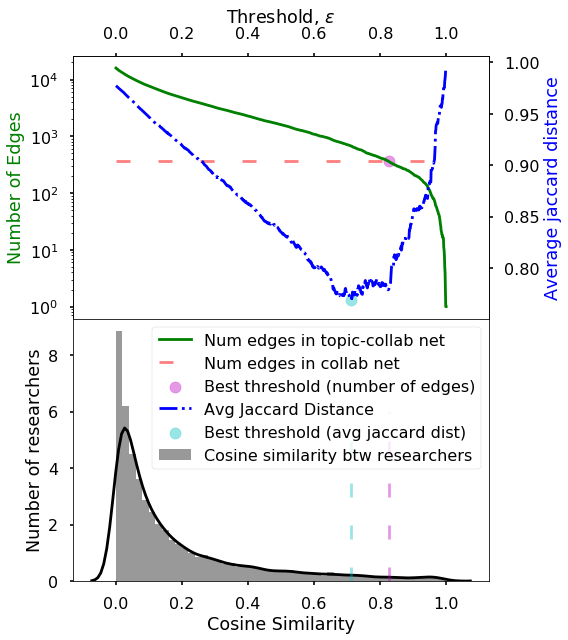

In [68]:
f = threshold_plot(thresholds, distances, edges, best_threshold, closest_edges,
                   best_j_dist_threshold, lowest_avg_distances,
                   np.sum(adj_mat) // 2, cosim)

In [ ]:
f.savefig('./IMG/topicnet6yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

In [ ]:
# ORIGINAL COLALB NET
f1 = plt.figure(figsize=(8, 8))
ax1 = f1.add_subplot(111)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
# ax1.set_title('infnet6yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
f2 = plt.figure(figsize=(8, 8))
ax2 = f2.add_subplot(111)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
# ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
f3 = plt.figure(figsize=(8, 8))
ax3 = f3.add_subplot(111)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
# ax3.set_title('topicnet6yr\n($\epsilon$={:.3f}, #Edges={})'.format(
#     best_threshold,
#     int(np.sum(topicnet_adj_mat) // 2)))

In [ ]:
f1.savefig('./IMG/topicnet6yr_adjmat_org.png')
f2.savefig('./IMG/topicnet6yr_adjmat_cosim.png')
f3.savefig('./IMG/topicnet6yr_adjmat_topicnet.png')

In [ ]:
jaccard_adj_mat = set_edges(cosim, best_j_dist_threshold, binary=True)
# jaccard matrix
f4 = plt.figure(figsize=(8, 8))
ax4 = f4.add_subplot(111)
ax4.axis('off')
sns.heatmap(jaccard_adj_mat, cbar=False, square=True, ax=ax4)

In [ ]:
f4.savefig('./IMG/topicnet6yr_adjmat_jaccard.png')

#### As networks:

In [69]:
g_topicnet6yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [70]:
print(nx.info(g_topicnet6yr))

Name: 
Type: Graph
Number of nodes: 152
Number of edges: 361
Average degree:   4.7500


2018-04-11 22:40:44,635 : INFO : SAVE_GRAPHS: False


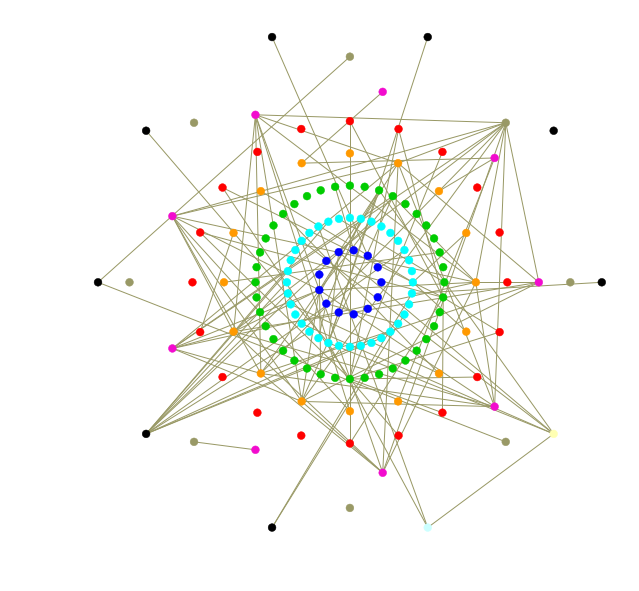

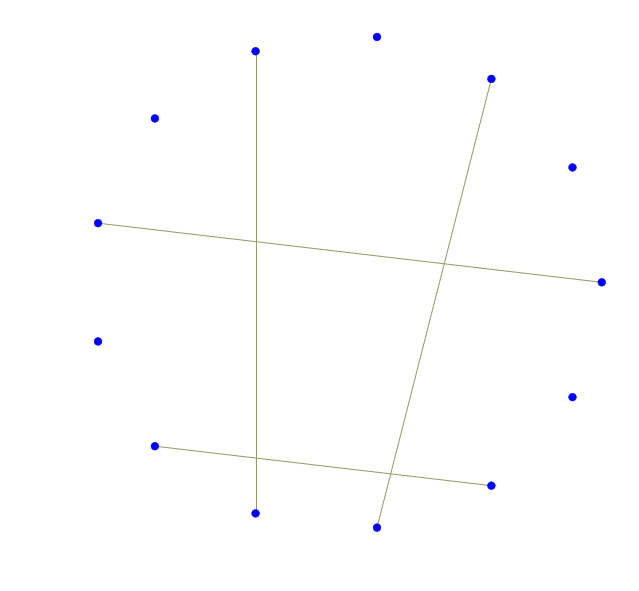

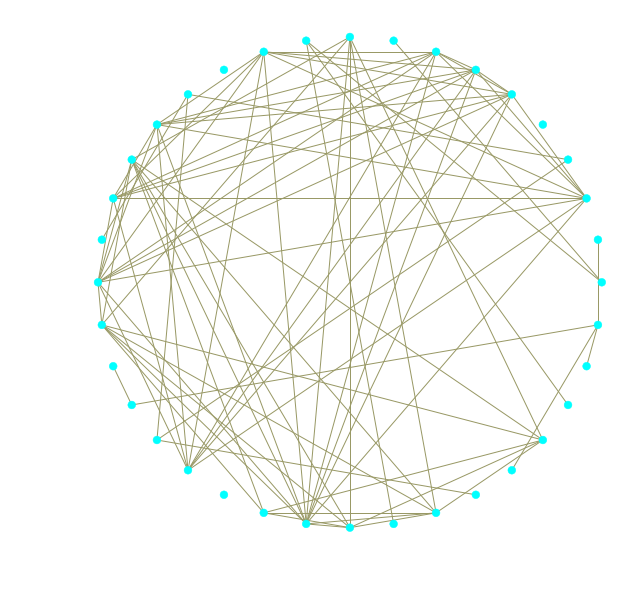

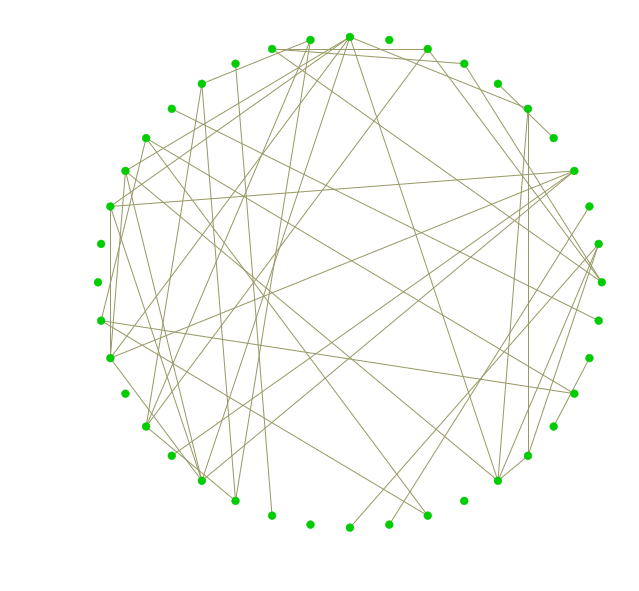

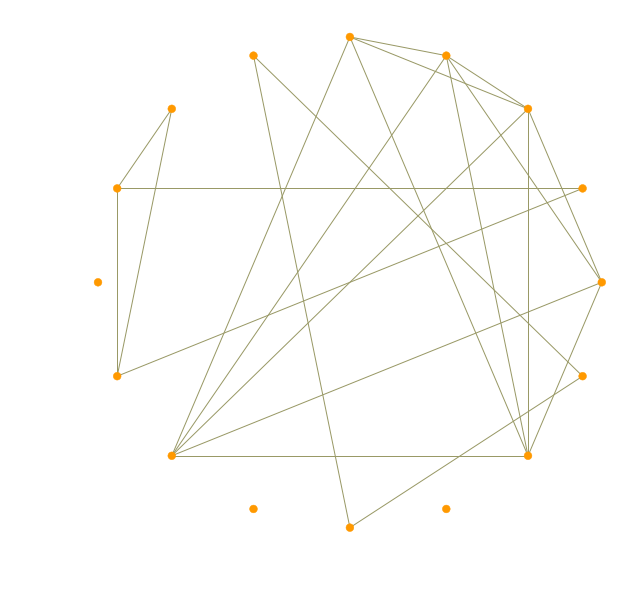

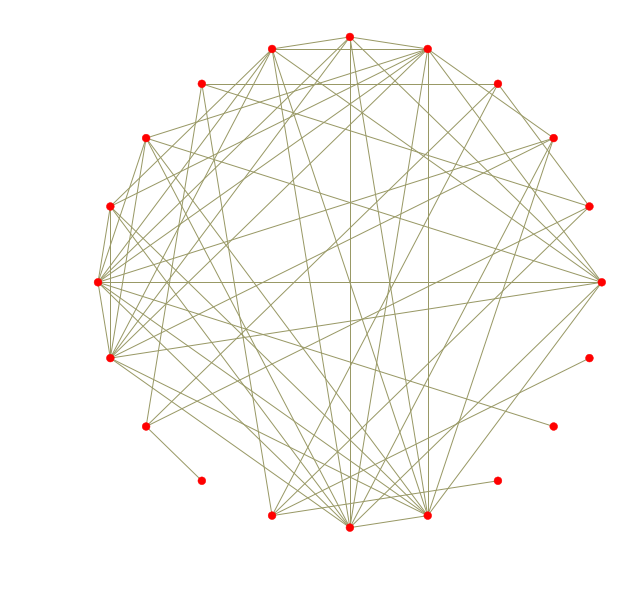

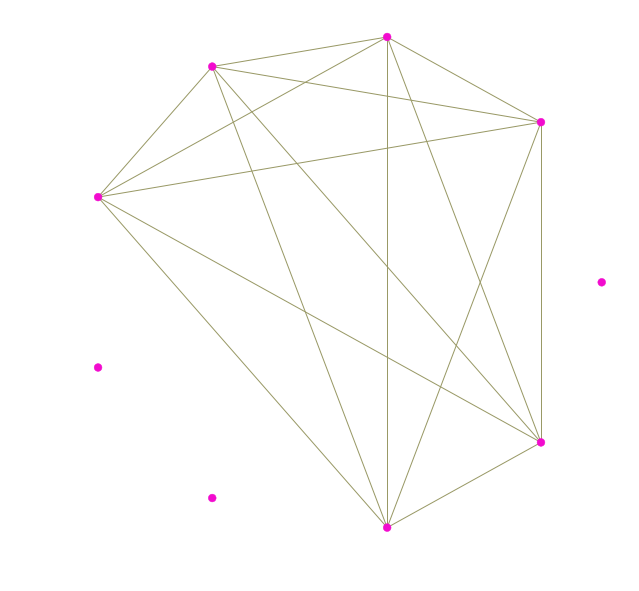

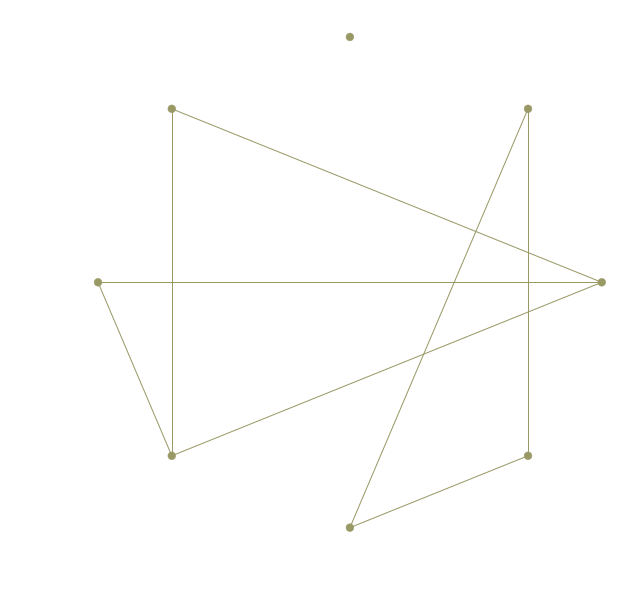

In [71]:
artist.draw_default_layout(
    g_topicnet6yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnet6yr',
    SAVE_GRAPHS=False)

2018-04-11 22:40:46,752 : INFO : SAVE_GRAPHS: False


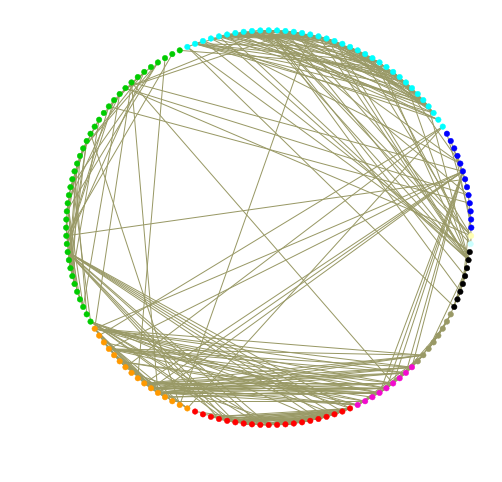

In [72]:
artist.draw_circular_layout(
    g_topicnet6yr,
    get_lookup_poinf(),
    file_prefix='topicnet6yr',
    SAVE_GRAPHS=False)

### Descriptive statistics

In [74]:
partition_dict = {}
topicnet['list_tm'] = topicnet.topic_probs.apply(lambda x: to_list(x, 30))

n = 0
for i, nodes in enumerate(nx.connected_components(g_topicnet6yr)):

    n += len(nodes)
    a = topicnet[topicnet.id.isin(nodes)].list_tm.tolist()
    topic_dist = np.mean(a, axis=0)
    partition_dict[i] = {
        'nodes': nodes,
        'topic_dist': topic_dist,
        'most_probable_topic': np.argmax(topic_dist)
    }

In [75]:
_pos = nx.spring_layout(g_topicnet6yr,k=.12, iterations=60)

In [76]:
topics= [19, 21, 27, 7, 28, 8,
        0, 23, 13, 10, 16,
        17, 12, 4, 15, 26,
        14, 22, 9, 29, 20,
        6, 2, 18, 25, 5,
        1, 3, 24, 11, ]
labels = ['Computational Linguistics', 'Speech Synthesis', 'IRR', 'Neural Network', 'IRR', 'Computer Vision',
         'Parallel Programming', 'Reasoning (?)','Bioinformatics','Machine Translation','Algorithms',
         'Social Media', '??', 'Compiler', 'Wireless Communication', 'Machine Learning',
         'Computer Simulation','Robot Control', 'Computer System', '??', 'Quantum Computing',
         'Computer Security', 'Database', 'Human Computer Interaction', 'Interaction System (?)', 'Modelling (?)',
         'Information Retrieval', 'Graph Theory', '??', '??']
TOPIC_DICT = dict((a,b) for a,b in zip(topics,labels))

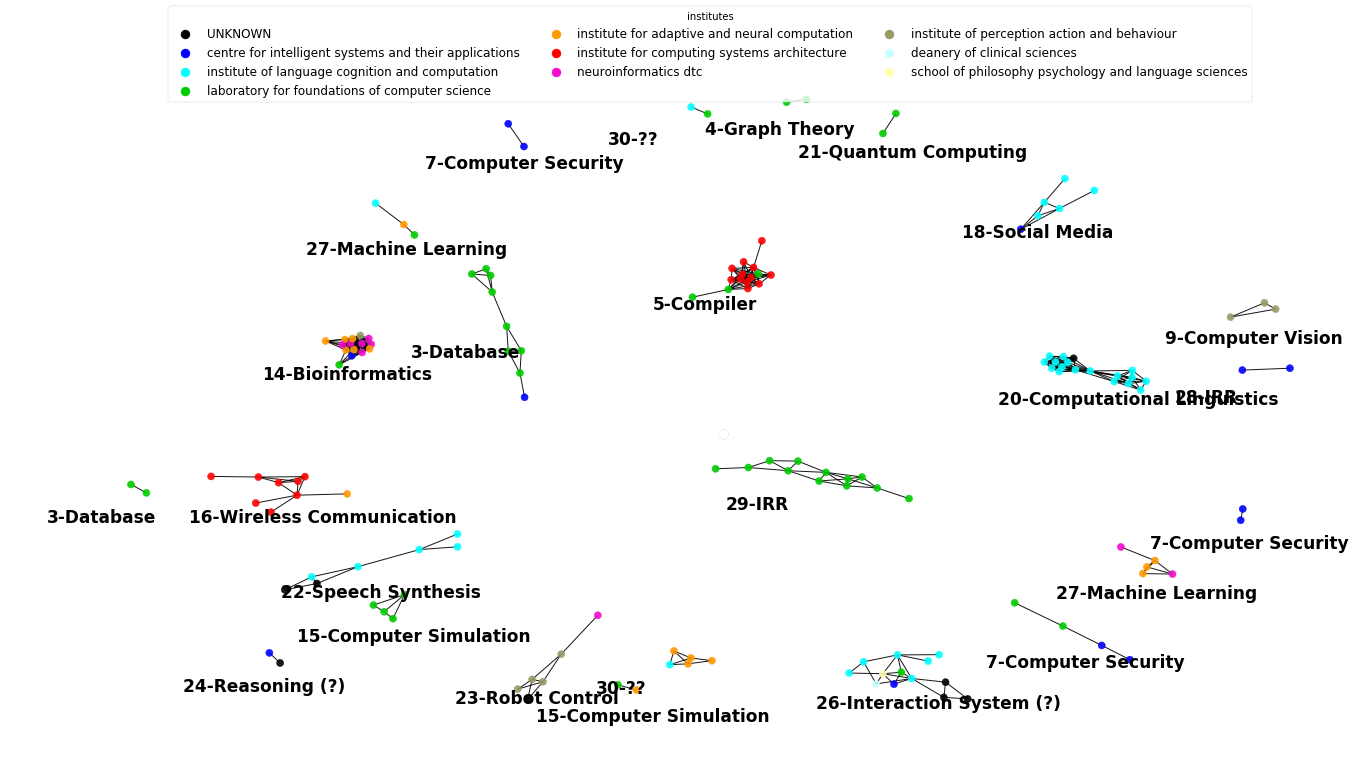

In [77]:
f = plt.figure(figsize=(19, 10))
ax = f.add_subplot(111)

nx.draw(
    g_topicnet6yr,
    pos=_pos,
    ax=ax,
    node_size=50,
    alpha=.9,
    node_color=artist.color_by_inst(g_topicnet6yr, get_lookup_poinf()))

for _, node_dict in list(partition_dict.items()):
    # calculate average position:
    pos_x, pos_y = 0, 0
    for node in node_dict['nodes']:
        pos_x += _pos[node][0]
        pos_y += _pos[node][1]
    pos_x /= len(node_dict['nodes'])
    pos_y /= len(node_dict['nodes'])
    topic_num = node_dict['most_probable_topic']
    ax.text(
        pos_x - .15,
        pos_y - .1,
        "{}-{}".format(topic_num + 1, TOPIC_DICT[topic_num]),
        withdash=True,
        size=17,
        weight='bold')
#     print((node_dict['most_probable_topic']))

artist.add_inst_labels(ax)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
    title='institutes',
    fontsize=12,
    fancybox=True,
    shadow=False)
f.tight_layout()

In [35]:
f.savefig('IMG/topicnet6yr_sping_w_topiclabel.pdf',format='pdf',bbox_inches='tight')

In [78]:
print(nx.average_clustering(g_topicnet6yr,count_zeros=False))
# clustering coefficient
c,avg = clustering_coeff(g_topicnet6yr)
print(avg)

0.7846849412269972
0.5523768994163731


In [79]:
nx.transitivity(g_topicnet6yr)

0.8257756563245824

In [80]:
a = nx.degree_histogram(g_topicnet6yr)
print(a[0]+a[1])

39


In [81]:
s=0
for i in nx.connected_components(g_topicnet6yr):
    s+=1
print(s)

25


### Using spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
spectral_c = SpectralClustering(n_clusters=24) # <- number of dimension of projection subspace

In [ ]:
topicnet['list_tm'] = topicnet.topic_probs.apply(lambda x: to_list(x,30))

In [ ]:
_x = topicnet.list_tm.tolist()

In [ ]:
spectral_clusters = spectral_c.fit_predict(X=_x)

In [ ]:
partition = {}
for i, n in enumerate(topicnet.id.tolist()):
    partition[n] = spectral_clusters[i]+1

In [ ]:
# create nx graph
lookup_pub = get_lookup_pub(2012,2017)
g_infnet6yr = nx.Graph()
# add edges:
poinf_list = get_lookup_poinf().index.tolist()
edges = lookup_pub.edges.tolist()
for e in edges:
    for (a, b) in e:
        if a in poinf_list and b in poinf_list:
            g_infnet6yr.add_edge(a, b)

In [ ]:
print(nx.info(g_infnet6yr))

In [ ]:
g_topicnet6yr_spectral = create_community_graph(partition, g_infnet6yr)

In [ ]:
_nodelist = [a for a in g_topicnet6yr_spectral if a in g_topicnet6yr]

In [ ]:
pos_infnet6yr = nx.spring_layout(g_infnet6yr)
pos_infnet6yr2 = nx.spring_layout(g_infnet6yr, pos=pos_infnet6yr)

In [ ]:
nx.draw(
    g_infnet6yr,
    pos=pos_infnet6yr2,
    node_size=30,
    node_color=artist.color_by_inst(g_infnet6yr, get_lookup_poinf()));

In [ ]:
nx.draw(
    g_topicnet6yr,
    pos=pos_infnet6yr2,
    node_size=30,
    node_color=artist.color_by_inst(g_topicnet6yr, get_lookup_poinf()));

In [ ]:
nx.draw(
    g_topicnet6yr_spectral,
#     pos=pos_infnet6yr2,
    node_size=30,
    node_color=artist.color_by_inst(g_topicnet6yr_spectral, get_lookup_poinf()));

## `topicnetref-6yr`
created using
1. infnet6yr
2. tm-dblp

### Deriving `topicnetref-6yr`

In [82]:
# Since we are using the same base, we do not need to reload it again!
# Loading the new topic model:
tm = models.LdaModel.load('../../topicModel/src/tmdblp/tm_dblp')
dict_tm = Dictionary.load(
    '../../data/data_dblp/corpora/dictionary.dblp.1997-2017')

2018-04-11 22:41:45,593 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp
2018-04-11 22:41:45,600 : INFO : loading expElogbeta from ../../topicModel/src/tmdblp/tm_dblp.expElogbeta.npy with mmap=None
2018-04-11 22:41:45,633 : INFO : setting ignored attribute id2word to None
2018-04-11 22:41:45,634 : INFO : setting ignored attribute dispatcher to None
2018-04-11 22:41:45,634 : INFO : setting ignored attribute state to None
2018-04-11 22:41:45,635 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp
2018-04-11 22:41:45,635 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp.state
2018-04-11 22:41:46,062 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp.state
2018-04-11 22:41:46,082 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-04-11 22:41:46,125 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [83]:
# Generate topic probabilities for each publication using the dictionary for DBLP
tm.minimum_probability = 0.001
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)) if len(a) else None)

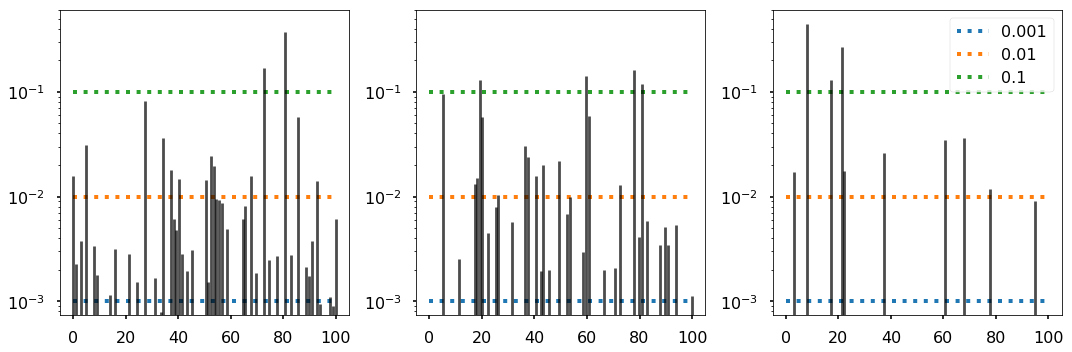

In [100]:
# start from 0 to get all the probs
tm.minimum_probability = 0.00
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)))
ls = ['-', '-.', '--', ':']
# ds = [(5,1),(5,5), (5,10), (5,20)]
marker = ['x', '^', 'd', 'p']
# try values for min probability:
f = plt.figure(figsize=(15, 5))
axes = []
xs = np.linspace(0, tm.num_topics, num=tm.num_topics)
# _xs = np.linspace(xs[0],xs[-1],300)
c = sns.color_palette(n_colors=3)
for i in range(3):
    if i == 0:
        ax = f.add_subplot(1, 3, i + 1)
    else:
        ax = f.add_subplot(1, 3, i + 1, sharey=ax)
    _probs = np.asarray([a[1] for a in topicnet.topic_probs.iloc[13 + i * 2]])

    for j, p in enumerate([0.001, 0.01, 0.1]):
        ax.hlines(
            p,
            xs[0],
            xs[-1],
            linestyles=':',
            linewidth=4,
            label='{}'.format(p),
            colors=c[j])
#         _probs[_probs <= p] = 0

#     ax.step(xs, _probs, alpha=0.7, linestyle='-', linewidth=4)

    ax.vlines(xs,[0],_probs,alpha=0.7 )
    #         ax.scatter(xs,_probs,,alpha=0.6,s=50,marker=marker[j])
    ax.set_yscale('log')
    axes.append(ax)
    ax.legend().set_visible(False)
h, l = axes[-1].get_legend_handles_labels()
axes[-1].legend(h, l, loc=0)
f.tight_layout()

In [101]:
f.savefig('IMG/try_min_probs_refdblp.png',format='png',bbox_inches='tight')

In [84]:
# Generate cosine similarity
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [85]:
# find best threshold
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-04-11 22:42:00,560 : INFO : Number of ground_truth_edges: 361.0
2018-04-11 22:42:00,561 : INFO : binary edges: True
2018-04-11 22:42:00,571 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.979 num_edges: 16799
2018-04-11 22:42:00,583 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.979 num_edges: 16784
2018-04-11 22:42:00,594 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.979 num_edges: 16770
2018-04-11 22:42:00,606 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.978 num_edges: 16744
2018-04-11 22:42:00,618 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.978 num_edges: 16710
2018-04-11 22:42:00,630 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.978 num_edges: 16684
2018-04-11 22:42:00,640 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.978 num_edges: 16653
2018-04-11 22:42:00,648 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.978 num_edges: 16609
2018-04-11 22:42:00,656 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.978 num_edges: 16557
2018-04-11 22:42:00,664 : INFO : epoch 9: threshold

2018-04-11 22:42:01,444 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.964 num_edges: 10723
2018-04-11 22:42:01,452 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.963 num_edges: 10660
2018-04-11 22:42:01,462 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.963 num_edges: 10594
2018-04-11 22:42:01,476 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.963 num_edges: 10537
2018-04-11 22:42:01,483 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.963 num_edges: 10474
2018-04-11 22:42:01,496 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.962 num_edges: 10411
2018-04-11 22:42:01,507 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.962 num_edges: 10362
2018-04-11 22:42:01,518 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.962 num_edges: 10308
2018-04-11 22:42:01,527 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.962 num_edges: 10256
2018-04-11 22:42:01,535 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.962 num_edges: 10186
2018-04-11 22:42:01,545 : INFO : epoch 97: threshold: 0.098 avg_dist: 

2018-04-11 22:42:02,274 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.940 num_edges: 6724
2018-04-11 22:42:02,283 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.940 num_edges: 6693
2018-04-11 22:42:02,295 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.940 num_edges: 6646
2018-04-11 22:42:02,306 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.939 num_edges: 6618
2018-04-11 22:42:02,314 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.939 num_edges: 6585
2018-04-11 22:42:02,320 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.938 num_edges: 6541
2018-04-11 22:42:02,331 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.938 num_edges: 6508
2018-04-11 22:42:02,338 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.938 num_edges: 6469
2018-04-11 22:42:02,346 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.938 num_edges: 6448
2018-04-11 22:42:02,355 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.937 num_edges: 6411
2018-04-11 22:42:02,363 : INFO : epoch 186: threshold: 0.187 avg_dist:

2018-04-11 22:42:03,018 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.913 num_edges: 4462
2018-04-11 22:42:03,025 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.912 num_edges: 4442
2018-04-11 22:42:03,033 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.912 num_edges: 4422
2018-04-11 22:42:03,043 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.911 num_edges: 4400
2018-04-11 22:42:03,050 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.911 num_edges: 4379
2018-04-11 22:42:03,058 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.911 num_edges: 4354
2018-04-11 22:42:03,065 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.910 num_edges: 4340
2018-04-11 22:42:03,073 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.910 num_edges: 4320
2018-04-11 22:42:03,080 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.909 num_edges: 4302
2018-04-11 22:42:03,093 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.909 num_edges: 4283
2018-04-11 22:42:03,100 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-04-11 22:42:03,761 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.881 num_edges: 3154
2018-04-11 22:42:03,770 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.881 num_edges: 3143
2018-04-11 22:42:03,778 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.881 num_edges: 3134
2018-04-11 22:42:03,784 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.880 num_edges: 3117
2018-04-11 22:42:03,791 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.879 num_edges: 3109
2018-04-11 22:42:03,799 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.879 num_edges: 3095
2018-04-11 22:42:03,809 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.879 num_edges: 3078
2018-04-11 22:42:03,816 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.878 num_edges: 3065
2018-04-11 22:42:03,824 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.877 num_edges: 3052
2018-04-11 22:42:03,831 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.877 num_edges: 3036
2018-04-11 22:42:03,838 : INFO : epoch 364: threshold: 0.365 avg_dist:

2018-04-11 22:42:04,491 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.849 num_edges: 2224
2018-04-11 22:42:04,500 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.847 num_edges: 2212
2018-04-11 22:42:04,509 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.846 num_edges: 2201
2018-04-11 22:42:04,517 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.846 num_edges: 2194
2018-04-11 22:42:04,525 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.846 num_edges: 2191
2018-04-11 22:42:04,532 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.846 num_edges: 2185
2018-04-11 22:42:04,541 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.846 num_edges: 2180
2018-04-11 22:42:04,549 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.847 num_edges: 2170
2018-04-11 22:42:04,557 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.847 num_edges: 2163
2018-04-11 22:42:04,564 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.846 num_edges: 2151
2018-04-11 22:42:04,571 : INFO : epoch 452: threshold: 0.453 avg_dist:

2018-04-11 22:42:05,185 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.817 num_edges: 1591
2018-04-11 22:42:05,193 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.816 num_edges: 1590
2018-04-11 22:42:05,202 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.815 num_edges: 1585
2018-04-11 22:42:05,209 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.815 num_edges: 1582
2018-04-11 22:42:05,217 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.813 num_edges: 1576
2018-04-11 22:42:05,224 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.811 num_edges: 1563
2018-04-11 22:42:05,235 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.810 num_edges: 1555
2018-04-11 22:42:05,248 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.809 num_edges: 1549
2018-04-11 22:42:05,261 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.809 num_edges: 1546
2018-04-11 22:42:05,270 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.808 num_edges: 1542
2018-04-11 22:42:05,280 : INFO : epoch 541: threshold: 0.542 avg_dist:

2018-04-11 22:42:05,913 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.791 num_edges: 1159
2018-04-11 22:42:05,920 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.790 num_edges: 1154
2018-04-11 22:42:05,927 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.789 num_edges: 1152
2018-04-11 22:42:05,934 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.790 num_edges: 1144
2018-04-11 22:42:05,946 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.789 num_edges: 1141
2018-04-11 22:42:05,954 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.789 num_edges: 1136
2018-04-11 22:42:05,963 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.789 num_edges: 1130
2018-04-11 22:42:05,969 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.788 num_edges: 1123
2018-04-11 22:42:05,978 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.788 num_edges: 1118
2018-04-11 22:42:05,986 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.787 num_edges: 1116
2018-04-11 22:42:05,997 : INFO : epoch 630: threshold: 0.631 avg_dist:

2018-04-11 22:42:06,638 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.785 num_edges: 800
2018-04-11 22:42:06,646 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.788 num_edges: 796
2018-04-11 22:42:06,655 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.788 num_edges: 790
2018-04-11 22:42:06,663 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.789 num_edges: 788
2018-04-11 22:42:06,670 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.788 num_edges: 787
2018-04-11 22:42:06,679 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.785 num_edges: 782
2018-04-11 22:42:06,685 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.783 num_edges: 778
2018-04-11 22:42:06,693 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.780 num_edges: 773
2018-04-11 22:42:06,701 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.781 num_edges: 771
2018-04-11 22:42:06,709 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.783 num_edges: 765
2018-04-11 22:42:06,716 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.783 num

2018-04-11 22:42:07,350 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.792 num_edges: 446
2018-04-11 22:42:07,357 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.792 num_edges: 445
2018-04-11 22:42:07,364 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.792 num_edges: 444
2018-04-11 22:42:07,371 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.791 num_edges: 442
2018-04-11 22:42:07,384 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.791 num_edges: 440
2018-04-11 22:42:07,392 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.795 num_edges: 437
2018-04-11 22:42:07,402 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.795 num_edges: 434
2018-04-11 22:42:07,410 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.799 num_edges: 429
2018-04-11 22:42:07,417 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.798 num_edges: 428
2018-04-11 22:42:07,425 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.800 num_edges: 424
2018-04-11 22:42:07,432 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.800 num

2018-04-11 22:42:08,063 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.852 num_edges: 201
2018-04-11 22:42:08,073 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.853 num_edges: 200
2018-04-11 22:42:08,085 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.853 num_edges: 196
2018-04-11 22:42:08,092 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.852 num_edges: 194
2018-04-11 22:42:08,099 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.852 num_edges: 191
2018-04-11 22:42:08,110 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.852 num_edges: 191
2018-04-11 22:42:08,117 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.852 num_edges: 188
2018-04-11 22:42:08,123 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.862 num_edges: 184
2018-04-11 22:42:08,130 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.866 num_edges: 182
2018-04-11 22:42:08,137 : INFO : epoch 898: threshold: 0.899 avg_dist: 0.871 num_edges: 179
2018-04-11 22:42:08,144 : INFO : epoch 899: threshold: 0.900 avg_dist: 0.869 num

2018-04-11 22:42:08,885 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.968 num_edges: 17
2018-04-11 22:42:08,894 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.968 num_edges: 17
2018-04-11 22:42:08,904 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.970 num_edges: 16
2018-04-11 22:42:08,916 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.976 num_edges: 15
2018-04-11 22:42:08,928 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.981 num_edges: 12
2018-04-11 22:42:08,935 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.981 num_edges: 12
2018-04-11 22:42:08,943 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.981 num_edges: 12
2018-04-11 22:42:08,954 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.982 num_edges: 10
2018-04-11 22:42:08,967 : INFO : epoch 987: threshold: 0.988 avg_dist: 0.986 num_edges: 8
2018-04-11 22:42:08,980 : INFO : epoch 988: threshold: 0.989 avg_dist: 0.988 num_edges: 7
2018-04-11 22:42:08,992 : INFO : epoch 989: threshold: 0.990 avg_dist: 0.990 num_edges: 5
20

threshold: 0.832 dist 0.769098 (675, 0.676) edges 361/361.0 (831)


threshold: 0.832 dist 0.767666 (672, 0.673) edges 361/360.0 (831)

In [86]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, 0.832, binary=True)
topicnet_adj_mat.dump('./res/topicnetref6yr_adjmat.pkl')

2018-04-11 22:42:10,149 : INFO : dimension: 184, 184


### Visualise

#### Thresholding:

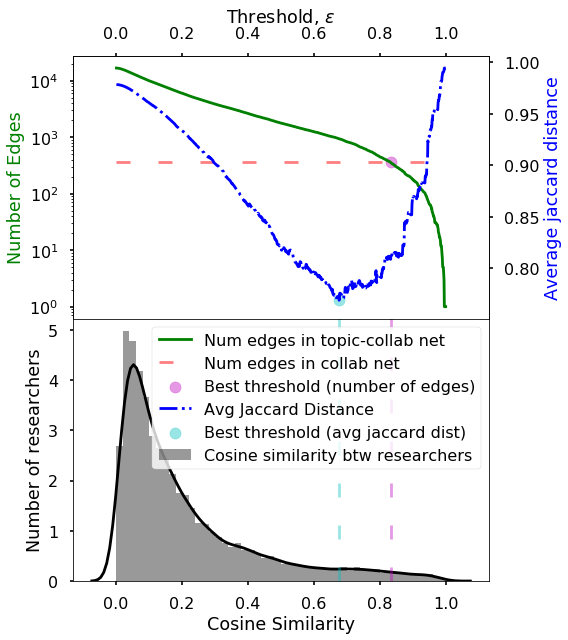

In [87]:
f = threshold_plot(thresholds, distances, edges, best_threshold, closest_edges,
                   best_j_dist_threshold, lowest_avg_distances,
                   np.sum(adj_mat) // 2, cosim)

In [ ]:
f.savefig(
    './IMG/topicnetref6yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

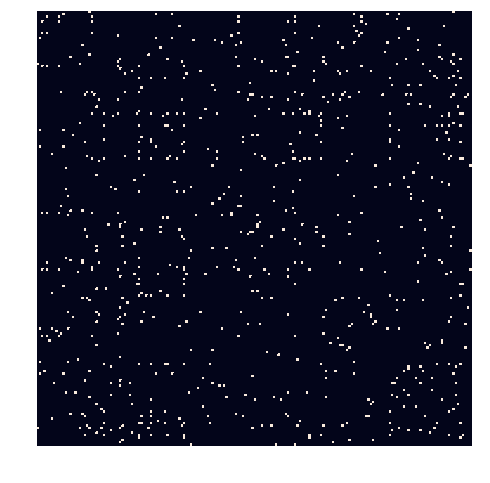

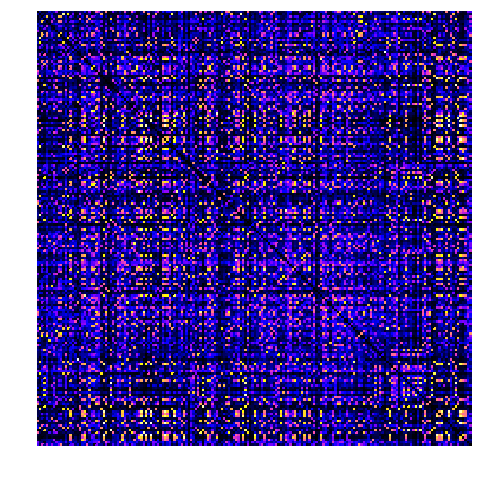

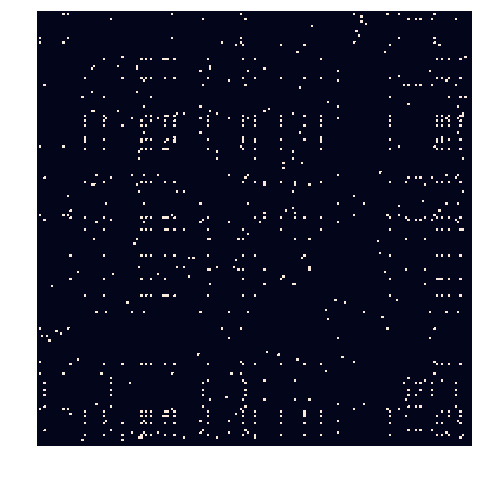

In [88]:
# ORIGINAL COLALB NET
f1 = plt.figure(figsize=(8, 8))
ax1 = f1.add_subplot(111)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
# ax1.set_title('infnet6yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
f2 = plt.figure(figsize=(8, 8))
ax2 = f2.add_subplot(111)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
# ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
f3 = plt.figure(figsize=(8, 8))
ax3 = f3.add_subplot(111)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
# ax3.set_title('topicnet6yr\n($\epsilon$={:.3f}, #Edges={})'.format(
#     best_threshold,
#     int(np.sum(topicnet_adj_mat) // 2)))

In [155]:
f3.savefig('./IMG/topicnetref6yr_adjmats_topicnet.png')

#### As networks:

In [89]:
g_topicnetref6yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [90]:
print(nx.info(g_topicnetref6yr))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 361
Average degree:   6.0672


2018-04-11 22:42:25,071 : INFO : SAVE_GRAPHS: True


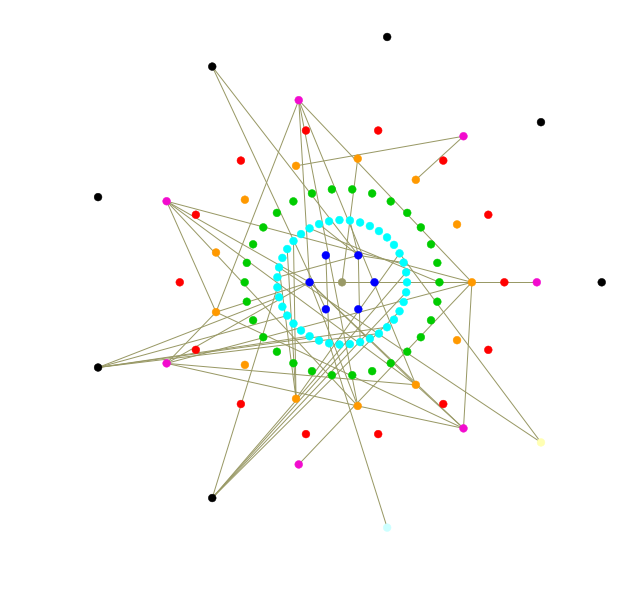

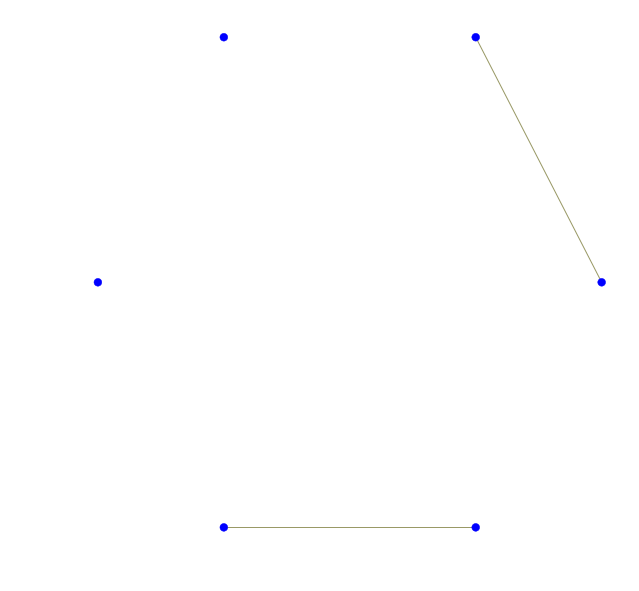

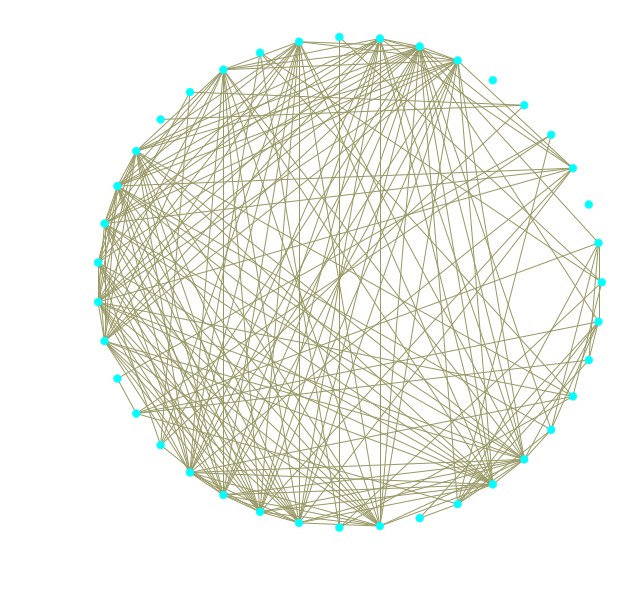

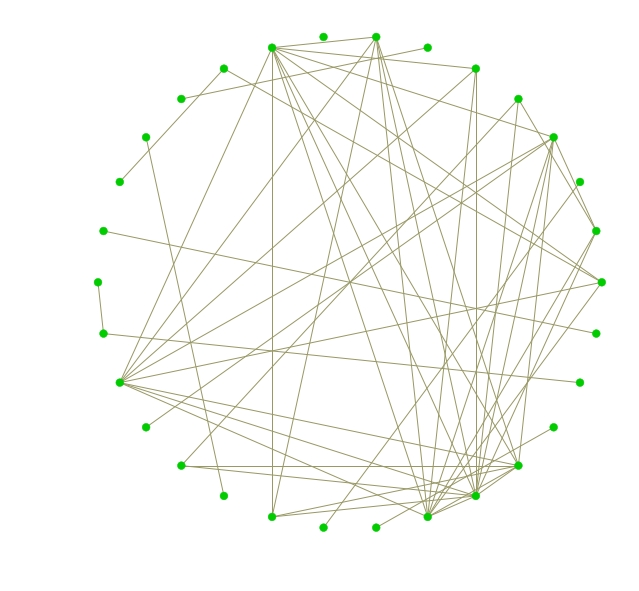

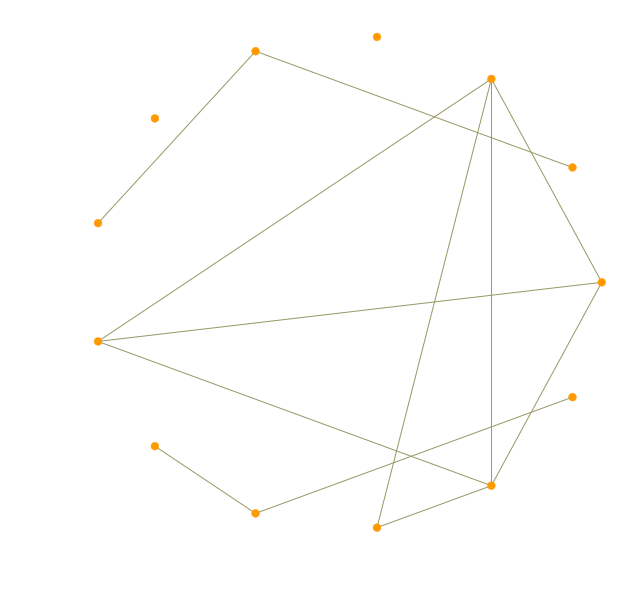

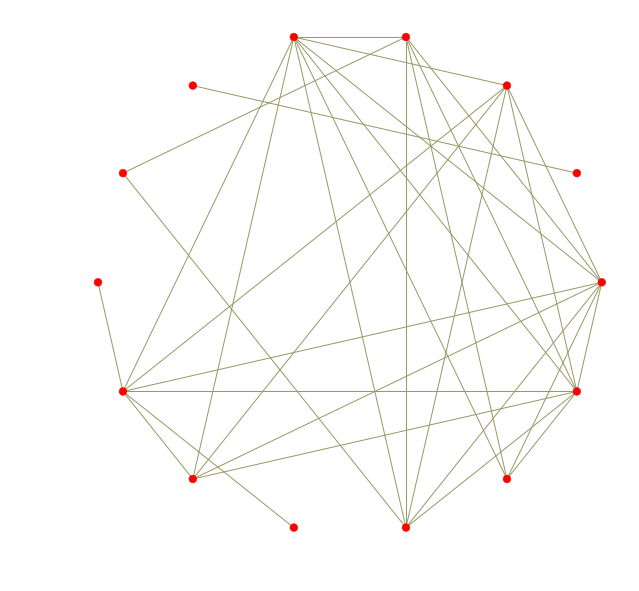

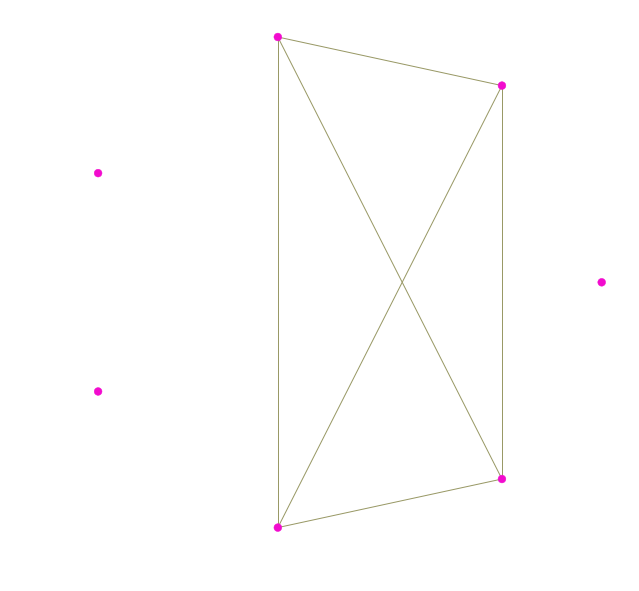

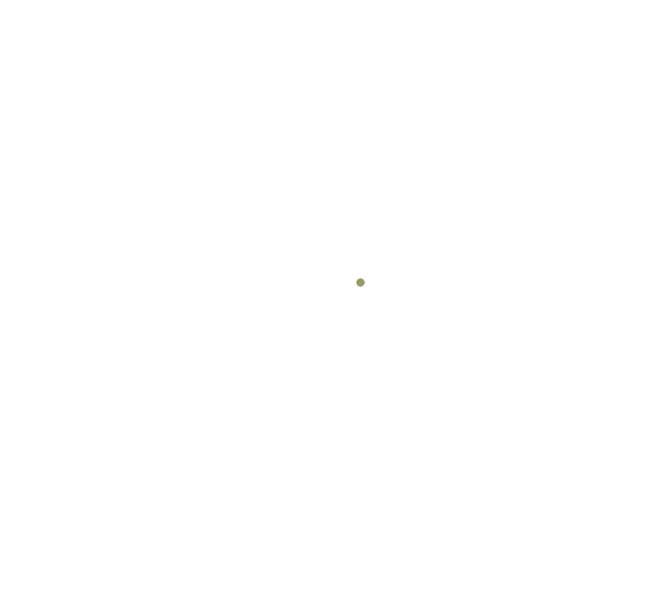

In [91]:
artist.draw_default_layout(
    g_topicnetref6yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref6yr',
    SAVE_GRAPHS=True)

2018-04-11 22:42:28,733 : INFO : SAVE_GRAPHS: True


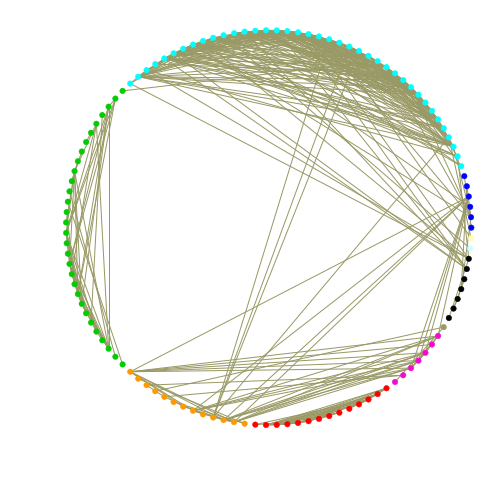

In [92]:
artist.draw_circular_layout(
    g_topicnetref6yr,
    get_lookup_poinf(),
    file_prefix='topicnetref6yr',
    SAVE_GRAPHS=True)

In [93]:
pos = nx.spring_layout(g_topicnetref6yr,iterations=70, scale=3)

80
76
64
96
59
69
17
95
8
40
8
36
71
23
52
96
5
2


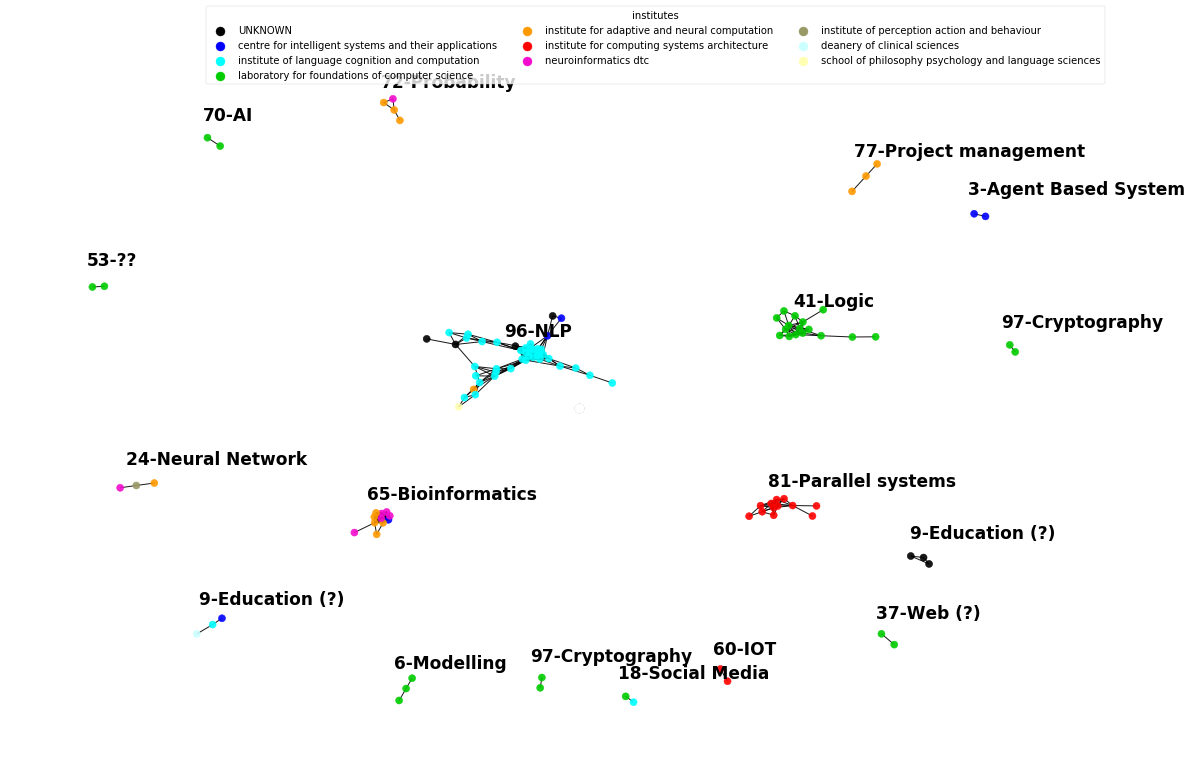

In [97]:
# Visualise with topic label
partition_dict = {}
topicnet['list_tm'] = topicnet.topic_probs.apply(lambda x: to_list(x, 100))

n = 0
for i, nodes in enumerate(nx.connected_components(g_topicnetref6yr)):

    n += len(nodes)
    a = topicnet[topicnet.id.isin(nodes)].list_tm.tolist()
    topic_dist = np.mean(a, axis=0)
    partition_dict[i] = {
        'nodes': nodes,
        'topic_dist': topic_dist,
        'most_probable_topic': np.argmax(topic_dist)
    }

# dblp_ = [(40 ,'Computer Networks'),
# (80 ,'??'),
# (76 ,'Computer architecture'),
# (64 ,'Linear Algebra'),
# (96 ,'IRR'),
# (43 ,'Transportation' ),
# (69 ,'OOP'),
# (71 ,'Formal Language'),
# (95 ,'Computer System'),
# (8 ,'IOT'),
# (36  ,'Speech Processing'),
# (73 ,'Genes'),
# (15 ,'Signal Processing'),
# (6, 'Computer Networks'),
# (57 ,'??'),
# (5 ,'Machine Learning'),
# (2, 'Management'),
# (23, 'Graph Theory'),
# (17, 'Control Theory'),
# (52, 'SVM'),
# (59, 'Neural Networks'),
# (1 ,'Algorithm')]
dblp_ = [(80, 'Parallel systems'),
(76, 'Project management'),
(64, 'Bioinformatics'),
(96, 'Cryptography'),
(59, 'IOT'),
(52, '??'),
(69, 'AI'),
(17, 'Social Media'),
(95, 'NLP'),
(8, 'Education (?)'),
(40, 'Logic'),
(36, 'Web (?)'),
(71, 'Probability'),
(23, 'Neural Network'),
(5, 'Modelling'),
(2, 'Agent Based System')
]

TOPIC_DICT = dict((a,b) for a,b in dblp_)

f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
nx.draw(
    g_topicnetref6yr,
    pos=pos,
    ax=ax,
    node_size=50,
    alpha=.9,
    node_color=artist.color_by_inst(g_topicnetref6yr, get_lookup_poinf()))

for _, node_dict in list(partition_dict.items()):
    # calculate average position:
    pos_x, pos_y = 0, 0
    for node in node_dict['nodes']:
        pos_x += pos[node][0]
        pos_y += pos[node][1]
    pos_x /= len(node_dict['nodes'])
    pos_y /= len(node_dict['nodes'])
    topic_num = node_dict['most_probable_topic']
    ax.text(
        pos_x-.07,
        pos_y + .2,
        "{}-{}".format(topic_num + 1, TOPIC_DICT[topic_num]),
        withdash=True,
        size=17,
        weight='bold')
    print((node_dict['most_probable_topic']))

artist.add_inst_labels(ax)
ax.legend(
#     loc=0,
    loc='upper center',
    bbox_to_anchor=(.6, 1.1),
    ncol=3,
    title='institutes',
    fontsize=10,
    fancybox=True,
    shadow=False)
f.tight_layout()

In [ ]:
f.savefig('IMG/topicnet6yrref_w_topic.pdf',format='pdf',bbox_inches='tight')

### Descriptive Statistics

In [98]:
gccs = generateGCC(g_topicnetref6yr)

component 1: 37.82%
component 2: 13.45%
component 3: 10.08%
component 4: 9.24%
component 5: 3.36%
component 6: 2.52%
component 7: 2.52%
component 8: 2.52%
component 9: 2.52%
component 10: 2.52%
component 11: 1.68%
component 12: 1.68%
component 13: 1.68%
component 14: 1.68%
component 15: 1.68%
component 16: 1.68%
component 17: 1.68%
component 18: 1.68%


In [99]:
nx.average_clustering(g_topicnet6yr,count_zeros=False)

0.7846849412269972

In [100]:
np.mean([a for a in c_coeff.values() if a>0])

0.8174458366359774

In [101]:
c_coeff , avg = clustering_coeff(g_topicnetref6yr)
print(avg)
print(nx.transitivity(g_topicnetref6yr))

0.5336909101780699
0.7741935483870968


In [102]:
nx.degree_histogram(g_topicnetref6yr)


[0, 32, 16, 6, 7, 7, 9, 4, 13, 4, 2, 1, 0, 1, 0, 0, 3, 1, 7, 4, 1, 0, 0, 0, 1]

## `topicnetref-6yr-w`
created using
1. infnet6yr-w
2. tm-dblp

### Deriving `topicnetref-6yr-w`

In [103]:
# load collab net infnet6yrw
collabnet = pd.read_csv(
    '../../data/data_schoolofinf/poinf_collabgraph_2012-2017_weighted.txt',sep='\n',names=['id'])
adj_mat = np.load(
    '../../data/data_schoolofinf/mat/infnet6yrs-weighted-adj-mat.order6yr.pkl')

In [104]:
# nothing to work on for topicmodel since it is the same topic model...
# Calculate cosine similairty:
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [105]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001,binary_edges=False)

2018-04-11 22:44:12,274 : INFO : min weight: 0.00101010101010101
2018-04-11 22:44:12,275 : INFO : Number of ground_truth_edges: 361
2018-04-11 22:44:12,275 : INFO : binary edges: False
2018-04-11 22:44:12,288 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.999 num_edges: 16799
2018-04-11 22:44:12,295 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.999 num_edges: 16784
2018-04-11 22:44:12,301 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.999 num_edges: 16770
2018-04-11 22:44:12,308 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.999 num_edges: 16744
2018-04-11 22:44:12,315 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.999 num_edges: 16710
2018-04-11 22:44:12,324 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.999 num_edges: 16684
2018-04-11 22:44:12,331 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.999 num_edges: 16653
2018-04-11 22:44:12,344 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.999 num_edges: 16609
2018-04-11 22:44:12,356 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.999 num_

2018-04-11 22:44:13,147 : INFO : epoch 86: threshold: 0.087 avg_dist: 0.998 num_edges: 10793
2018-04-11 22:44:13,157 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.998 num_edges: 10723
2018-04-11 22:44:13,170 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.998 num_edges: 10660
2018-04-11 22:44:13,179 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.998 num_edges: 10594
2018-04-11 22:44:13,193 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.998 num_edges: 10537
2018-04-11 22:44:13,206 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.998 num_edges: 10474
2018-04-11 22:44:13,221 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.998 num_edges: 10411
2018-04-11 22:44:13,235 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.998 num_edges: 10362
2018-04-11 22:44:13,242 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.998 num_edges: 10308
2018-04-11 22:44:13,253 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.998 num_edges: 10256
2018-04-11 22:44:13,261 : INFO : epoch 96: threshold: 0.097 avg_dist: 

2018-04-11 22:44:13,969 : INFO : epoch 175: threshold: 0.176 avg_dist: 0.997 num_edges: 6752
2018-04-11 22:44:13,981 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.997 num_edges: 6724
2018-04-11 22:44:13,991 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.997 num_edges: 6693
2018-04-11 22:44:13,998 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.997 num_edges: 6646
2018-04-11 22:44:14,005 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.997 num_edges: 6618
2018-04-11 22:44:14,012 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.997 num_edges: 6585
2018-04-11 22:44:14,023 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.997 num_edges: 6541
2018-04-11 22:44:14,035 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.997 num_edges: 6508
2018-04-11 22:44:14,043 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.996 num_edges: 6469
2018-04-11 22:44:14,050 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.996 num_edges: 6448
2018-04-11 22:44:14,057 : INFO : epoch 185: threshold: 0.186 avg_dist:

2018-04-11 22:44:14,714 : INFO : epoch 264: threshold: 0.265 avg_dist: 0.994 num_edges: 4483
2018-04-11 22:44:14,724 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.994 num_edges: 4462
2018-04-11 22:44:14,732 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.994 num_edges: 4442
2018-04-11 22:44:14,740 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.994 num_edges: 4422
2018-04-11 22:44:14,747 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.994 num_edges: 4400
2018-04-11 22:44:14,754 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.994 num_edges: 4379
2018-04-11 22:44:14,761 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.994 num_edges: 4354
2018-04-11 22:44:14,770 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.994 num_edges: 4340
2018-04-11 22:44:14,784 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.994 num_edges: 4320
2018-04-11 22:44:14,792 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.994 num_edges: 4302
2018-04-11 22:44:14,799 : INFO : epoch 274: threshold: 0.275 avg_dist:

2018-04-11 22:44:15,463 : INFO : epoch 353: threshold: 0.354 avg_dist: 0.988 num_edges: 3160
2018-04-11 22:44:15,471 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.988 num_edges: 3154
2018-04-11 22:44:15,479 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.988 num_edges: 3143
2018-04-11 22:44:15,488 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.988 num_edges: 3134
2018-04-11 22:44:15,495 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.988 num_edges: 3117
2018-04-11 22:44:15,505 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.988 num_edges: 3109
2018-04-11 22:44:15,517 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.988 num_edges: 3095
2018-04-11 22:44:15,525 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.988 num_edges: 3078
2018-04-11 22:44:15,532 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.988 num_edges: 3065
2018-04-11 22:44:15,539 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.988 num_edges: 3052
2018-04-11 22:44:15,547 : INFO : epoch 363: threshold: 0.364 avg_dist:

2018-04-11 22:44:16,162 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.984 num_edges: 2224
2018-04-11 22:44:16,171 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.983 num_edges: 2212
2018-04-11 22:44:16,181 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.983 num_edges: 2201
2018-04-11 22:44:16,191 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.983 num_edges: 2194
2018-04-11 22:44:16,198 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.983 num_edges: 2191
2018-04-11 22:44:16,205 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.983 num_edges: 2185
2018-04-11 22:44:16,218 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.983 num_edges: 2180
2018-04-11 22:44:16,226 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.983 num_edges: 2170
2018-04-11 22:44:16,233 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.983 num_edges: 2163
2018-04-11 22:44:16,240 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.983 num_edges: 2151
2018-04-11 22:44:16,248 : INFO : epoch 452: threshold: 0.453 avg_dist:

2018-04-11 22:44:16,856 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.977 num_edges: 1591
2018-04-11 22:44:16,864 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.977 num_edges: 1590
2018-04-11 22:44:16,873 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.977 num_edges: 1585
2018-04-11 22:44:16,880 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.977 num_edges: 1582
2018-04-11 22:44:16,888 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.975 num_edges: 1576
2018-04-11 22:44:16,895 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.975 num_edges: 1563
2018-04-11 22:44:16,903 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.975 num_edges: 1555
2018-04-11 22:44:16,913 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.975 num_edges: 1549
2018-04-11 22:44:16,924 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.975 num_edges: 1546
2018-04-11 22:44:16,931 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.975 num_edges: 1542
2018-04-11 22:44:16,938 : INFO : epoch 541: threshold: 0.542 avg_dist:

2018-04-11 22:44:17,556 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.971 num_edges: 1159
2018-04-11 22:44:17,568 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.971 num_edges: 1154
2018-04-11 22:44:17,577 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.971 num_edges: 1152
2018-04-11 22:44:17,584 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.971 num_edges: 1144
2018-04-11 22:44:17,594 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.971 num_edges: 1141
2018-04-11 22:44:17,607 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.971 num_edges: 1136
2018-04-11 22:44:17,615 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.971 num_edges: 1130
2018-04-11 22:44:17,624 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.971 num_edges: 1123
2018-04-11 22:44:17,632 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.971 num_edges: 1118
2018-04-11 22:44:17,640 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.971 num_edges: 1116
2018-04-11 22:44:17,653 : INFO : epoch 630: threshold: 0.631 avg_dist:

2018-04-11 22:44:18,317 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.966 num_edges: 800
2018-04-11 22:44:18,324 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.966 num_edges: 796
2018-04-11 22:44:18,332 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.966 num_edges: 790
2018-04-11 22:44:18,339 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.966 num_edges: 788
2018-04-11 22:44:18,347 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.966 num_edges: 787
2018-04-11 22:44:18,353 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.966 num_edges: 782
2018-04-11 22:44:18,361 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.966 num_edges: 778
2018-04-11 22:44:18,371 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.966 num_edges: 773
2018-04-11 22:44:18,378 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.966 num_edges: 771
2018-04-11 22:44:18,386 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.965 num_edges: 765
2018-04-11 22:44:18,393 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.965 num

2018-04-11 22:44:19,050 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.968 num_edges: 446
2018-04-11 22:44:19,058 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.968 num_edges: 445
2018-04-11 22:44:19,069 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.968 num_edges: 444
2018-04-11 22:44:19,077 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.968 num_edges: 442
2018-04-11 22:44:19,084 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.968 num_edges: 440
2018-04-11 22:44:19,090 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.972 num_edges: 437
2018-04-11 22:44:19,097 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.972 num_edges: 434
2018-04-11 22:44:19,104 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.972 num_edges: 429
2018-04-11 22:44:19,111 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.972 num_edges: 428
2018-04-11 22:44:19,119 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.972 num_edges: 424
2018-04-11 22:44:19,125 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.972 num

2018-04-11 22:44:19,819 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.993 num_edges: 201
2018-04-11 22:44:19,826 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.993 num_edges: 200
2018-04-11 22:44:19,837 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.992 num_edges: 196
2018-04-11 22:44:19,845 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.992 num_edges: 194
2018-04-11 22:44:19,852 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.992 num_edges: 191
2018-04-11 22:44:19,858 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.992 num_edges: 191
2018-04-11 22:44:19,864 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.992 num_edges: 188
2018-04-11 22:44:19,872 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.992 num_edges: 184
2018-04-11 22:44:19,880 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.992 num_edges: 182
2018-04-11 22:44:19,888 : INFO : epoch 898: threshold: 0.899 avg_dist: 0.992 num_edges: 179
2018-04-11 22:44:19,895 : INFO : epoch 899: threshold: 0.900 avg_dist: 0.991 num

2018-04-11 22:44:20,529 : INFO : epoch 979: threshold: 0.980 avg_dist: 1.000 num_edges: 17
2018-04-11 22:44:20,536 : INFO : epoch 980: threshold: 0.981 avg_dist: 1.000 num_edges: 17
2018-04-11 22:44:20,542 : INFO : epoch 981: threshold: 0.982 avg_dist: 1.000 num_edges: 16
2018-04-11 22:44:20,549 : INFO : epoch 982: threshold: 0.983 avg_dist: 1.000 num_edges: 15
2018-04-11 22:44:20,556 : INFO : epoch 983: threshold: 0.984 avg_dist: 1.000 num_edges: 12
2018-04-11 22:44:20,564 : INFO : epoch 984: threshold: 0.985 avg_dist: 1.000 num_edges: 12
2018-04-11 22:44:20,572 : INFO : epoch 985: threshold: 0.986 avg_dist: 1.000 num_edges: 12
2018-04-11 22:44:20,581 : INFO : epoch 986: threshold: 0.987 avg_dist: 1.000 num_edges: 10
2018-04-11 22:44:20,588 : INFO : epoch 987: threshold: 0.988 avg_dist: 1.000 num_edges: 8
2018-04-11 22:44:20,597 : INFO : epoch 988: threshold: 0.989 avg_dist: 1.000 num_edges: 7
2018-04-11 22:44:20,605 : INFO : epoch 989: threshold: 0.990 avg_dist: 1.000 num_edges: 5
20

threshold: 0.832 dist 0.965399 (721, 0.722) edges 361/361 (831)


threshold: 0.832 dist 0.965210 (721, 0.722) edges 361/360 (831)

In [106]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=False) # the edges are the cosine similarities!
# topicnet_adj_mat.dump('./res/topicnetref6yr_adjmat.pkl')

2018-04-11 22:44:20,695 : INFO : dimension: 184, 184


### Visualise

#### Thresholding:

In [ ]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat, cosim
)

In [ ]:
f.savefig(
    './IMG/topicnetref6yrw_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

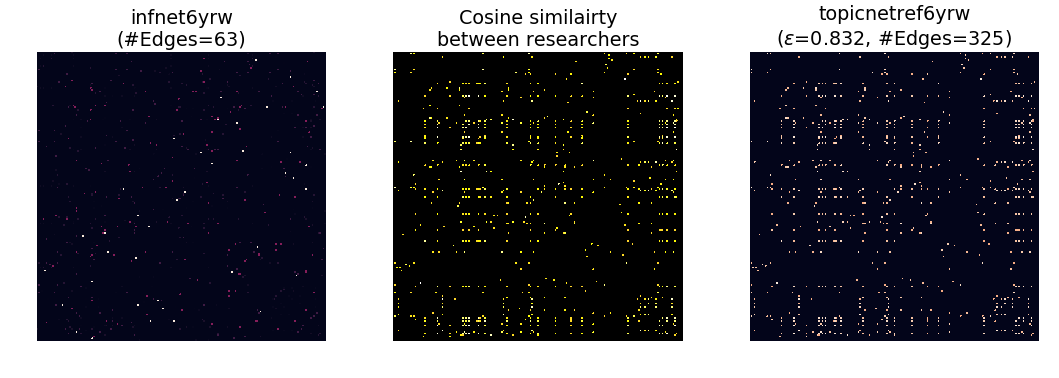

In [108]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet6yrw\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnetref6yrw\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [ ]:
f.savefig('./IMG/topicnetref6yr_adjmats.png')

#### As networks:

In [109]:
g_topicnetref6yrw = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [110]:
print(nx.info(g_topicnetref6yrw))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 361
Average degree:   6.0672


2018-04-11 22:45:03,640 : INFO : SAVE_GRAPHS: False


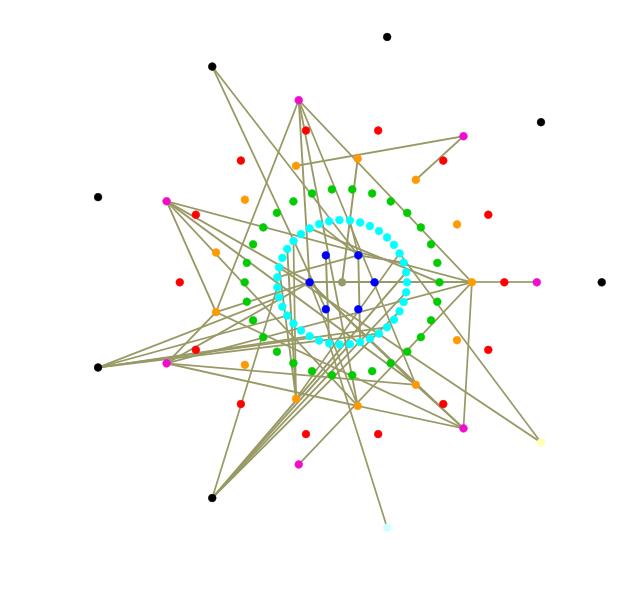

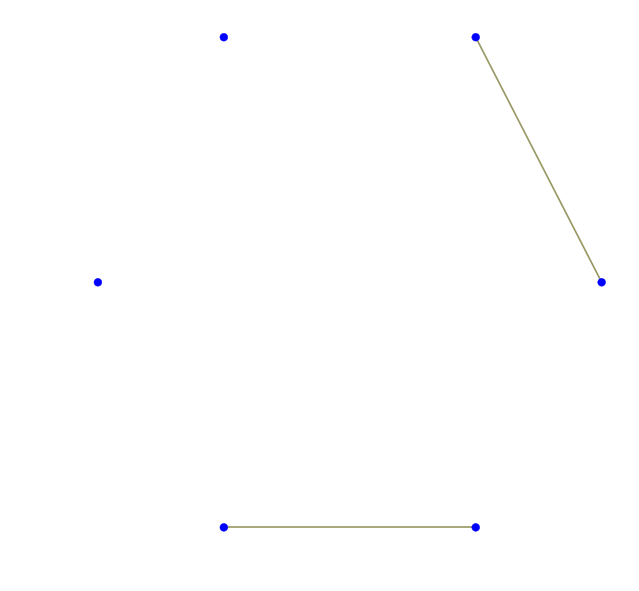

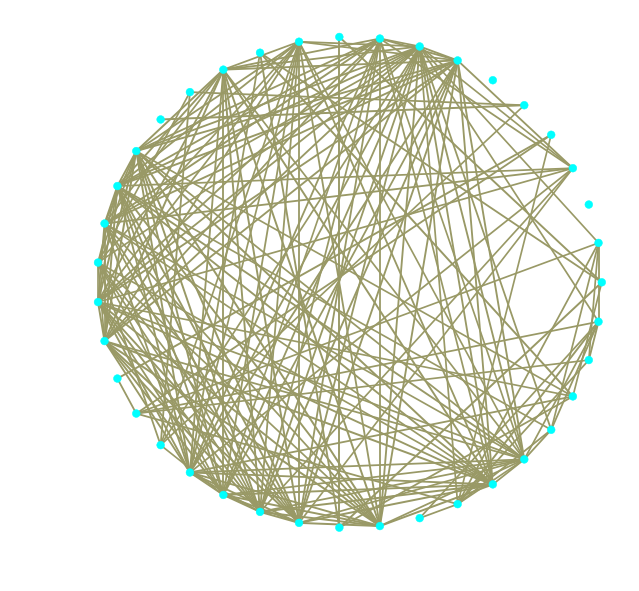

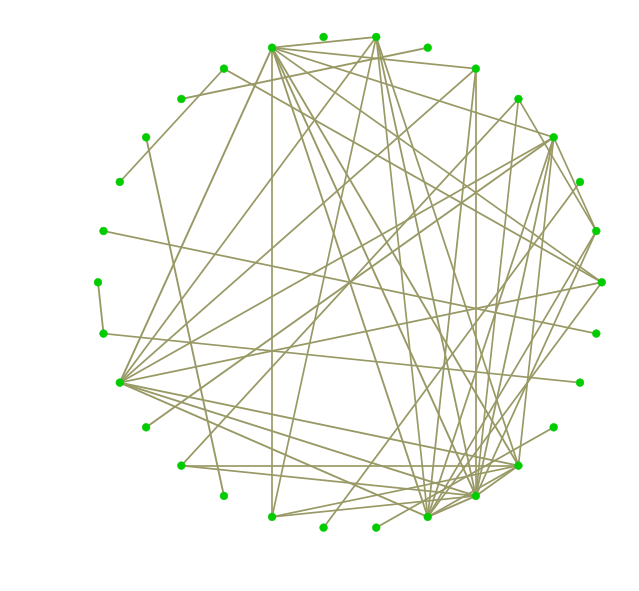

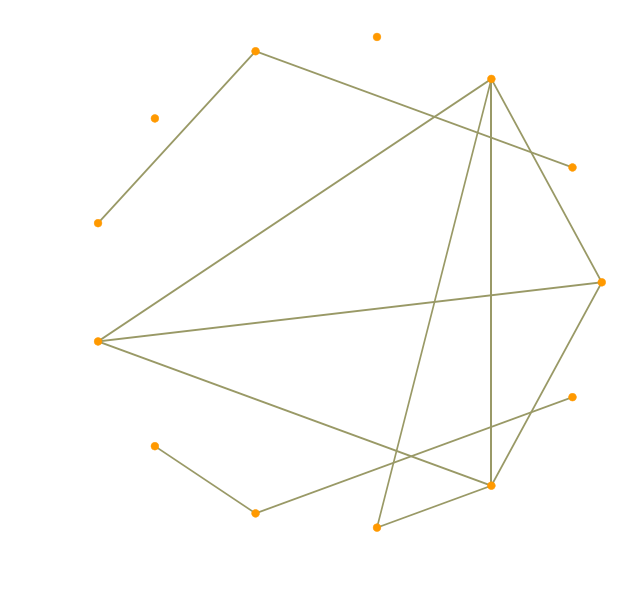

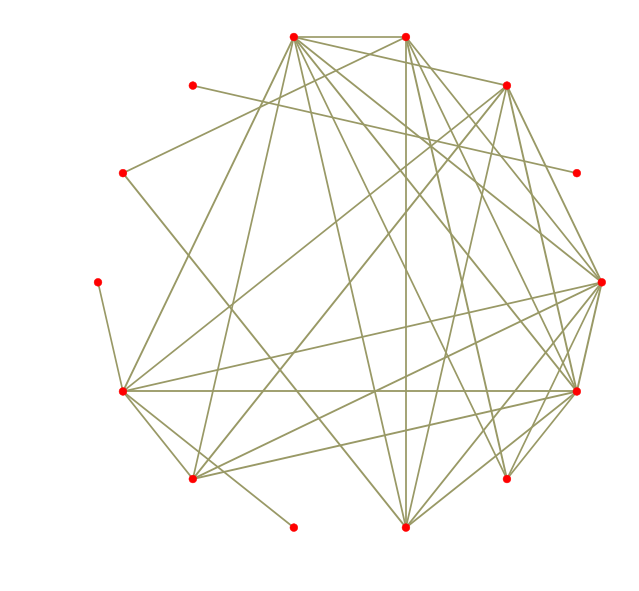

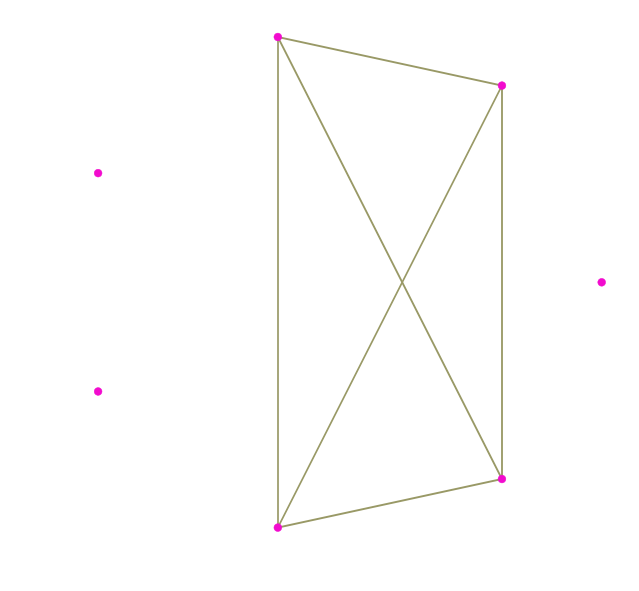

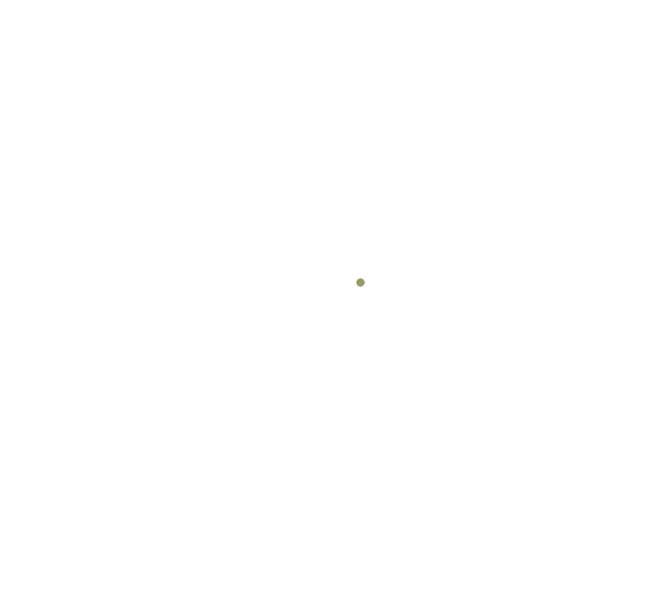

In [111]:
artist.draw_default_layout(
    g_topicnetref6yrw,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref6yrw',
    with_weight=True,scale=2,
    SAVE_GRAPHS=False)

2018-04-11 22:45:06,890 : INFO : SAVE_GRAPHS: False


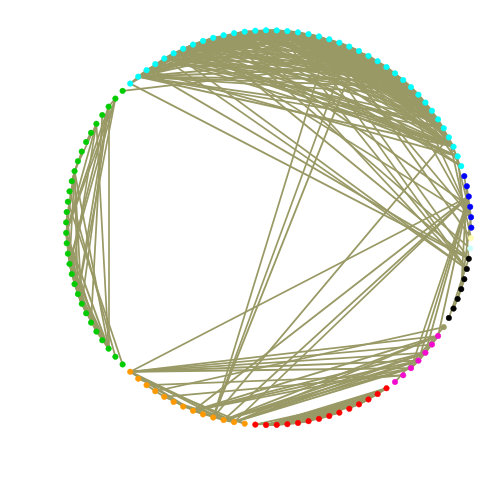

In [112]:
artist.draw_circular_layout(
    g_topicnetref6yrw,
    get_lookup_poinf(),
    file_prefix='topicnetref6yrw',
    with_weight=True,
    SAVE_GRAPHS=False)

### Descriptive Statistics

In [114]:
_x = nx.average_clustering(g_topicnetref6yrw, count_zeros=False, weight='weight')
print(_x)
_dict = nx.clustering(g_topicnetref6yrw, weight='weight')
print((np.mean(list(_dict.values()))))

0.6997657843413585
0.4821915488738774


In [115]:
print(nx.transitivity(g_topicnetref6yrw))

0.7741935483870968


In [116]:
x = nx.degree_histogram(g_topicnetref6yrw)
print(x[0]+x[1])

32
